### Jupyter for making figure for fastDMF+plastic FIC
#### I.- Inhibitory homeostatic plasticity rule enhances model stability and plausibility
    
    1.- Decay vs Learning rate relationship for different objective firing rates    
    2.- Firing Rate comparison between static vs dynamic FIC    
    3.- Convergence of dynamic FIC to the linear solution
    4.- Comparison of firing rate under neuromodulation


#### II.- Fitting to fMRI

    1.- Objective function for static and dynamics FIC for FC    
    2.- Violin plot of the fit to FC at the optimum    
    3.- Objective function for static and dynamics FIC for FCD    
    4.- Violin plot of the fit to FCD at the optimum


#### III.- A potential mechanism for whole-brain slow-waves
    1.- G vs LR Parameter space with autocorrelation peak
    2.- G vs LR Parameter space with autocorrelation time to peak
    3.- Average firing rate trace at slow wave region
    4.- Average firing rate trace at no-slow wave region (best fit to wake data)

In [2]:
# ! pip install mat73

In [2]:
import os
import time
import seaborn as sns
import numpy as np
import pandas as pd
# import fastdyn_fic_dmf as dmf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy import stats
import mat73
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
from matplotlib.gridspec import GridSpec


### I.- Inhibitory homeostatic plasticity rule enhances model stability and plausibility

In [3]:
# Loading data
# datafolder = 'C:/Users/rherz/OneDrive/Documents/Projects/dynFIC/data2plot/'
# figfold = 'C:/Users/rherz/OneDrive/Documents/Projects/dynFIC/paper_fig/paper_figs/figures/'
#datafolder = '/home/ruben.herzog/OneDrive/Projects/dynFIC/data2plot/'
#figfold = '/home/ruben.herzog/OneDrive/Projects/dynFIC/paper_figs/figures/'
datafolder = '/home/ivan.mindlin/Desktop/DatosParaRuben/'
figfold = '/home/ivan.mindlin/Desktop/DatosParaRuben/Figuras/panels/'
# Homeostatic fit
hom_fit_list = [] # 0=1.22, 1=3.44, 2=6.88, 3=50
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit1-22-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit3-44-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit6-88-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit50-Grid/hom_grid.npy'))

fic_corr = np.load(datafolder+'ChequeoPreliminar/fic_cor_timeseries_grid.npy')

# Static vs Dynamic FIC comparison
all_rates_stat = np.load(datafolder+'ChequeoPreliminar/avg_fr_stat_values.npy')
all_rates_dyn = np.load(datafolder+'ChequeoPreliminar/avg_fr_dyn_values.npy')
fic_t = np.load(datafolder+'ChequeoPreliminar/dyn_fic_values.npy')
static_fic = np.load(datafolder+'ChequeoPreliminar/stat_fic_values.npy')

# Neuromodulation
nm_mean_fr = [] # 0 is static, 1 dynamic
nm_std_fr = [] # 0 is static, 1 dynamic
nm_fc = [] # 0 is static, 1 dynamic
nm_fcd = [] # 0 is static, 1 dynamic
nm_mean_fr.append(np.load(datafolder+'neuromod/staticD2/mean_fr_grid.npy'))
nm_mean_fr.append(np.load(datafolder+'neuromod/dynamicD2/mean_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/staticD2/std_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/dynamicD2/std_fr_grid.npy'))
# nm_fc.append(np.load(datafolder+'neuromod/static/mean_fc_grid.npy'))
# nm_fc.append(np.load(datafolder+'neuromod/dynamic/mean_fc_grid.npy'))
# nm_fcd.append(np.load(datafolder+'neuromod/static/sim_stds_grid.npy'))
# nm_fcd.append(np.load(datafolder+'neuromod/dynamic/sim_stds_grid.npy'))

# Slow waves
peak_val_ac_grid = np.load(datafolder+'slow_waves/peak_autocorrelation_grid.npy')
peak_time_ac_grid = np.load(datafolder+'slow_waves/peak_time_grid.npy')
corr_to_sc_grid = np.load(datafolder+'slow_waves/corr_to_sc_grid.npy')
rates_grid = np.load(datafolder+'slow_waves/rates_grid.npy')
homeo_fit_grid = np.load(datafolder+'slow_waves/homeostatic_fittness_grid.npy')

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12
COLORBAR = 14


#### Homeostatic Fit

In [10]:
# HOMEOSTATIC FIT
# Extracting averages over the range of G
G_range = np.arange(0,8.5, 0.5)
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
obj_rates = [1.22, 3.44, 6.88, 50]

nobjs = len(obj_rates)
ngs = len(G_range)
nlr = len(LR_range)
ndec = len(DECAY_range)
lr_labels = [1, 10, 100, 1000]
dec_labels = [100, 1000, 10000, 100000]

# Mean and average over G
mean_hom_fit = [np.mean(x,axis=2) for x in hom_fit_list]
std_hom_fit = [np.std(x,axis=2) for x in hom_fit_list]

# Extracting Minimum mismatch
min_mm_pos = [np.argmin(np.abs(x),axis=0) for x in mean_hom_fit]

# Fitting linear trend
fit_res = list()
fit_res_2plot = list()
for o in range(nobjs):
    if o==0:
        fit_res.append(np.polyfit(LR_range[21:], min_mm_pos[o][21:], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr)[21:], min_mm_pos[o][21:], 1))
    else:
        fit_res.append(np.polyfit(LR_range, min_mm_pos[o], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr), min_mm_pos[o], 1))    
    


### Acá falta el plot con la correlación del promedio del FIC vs la fuerza de conectividad

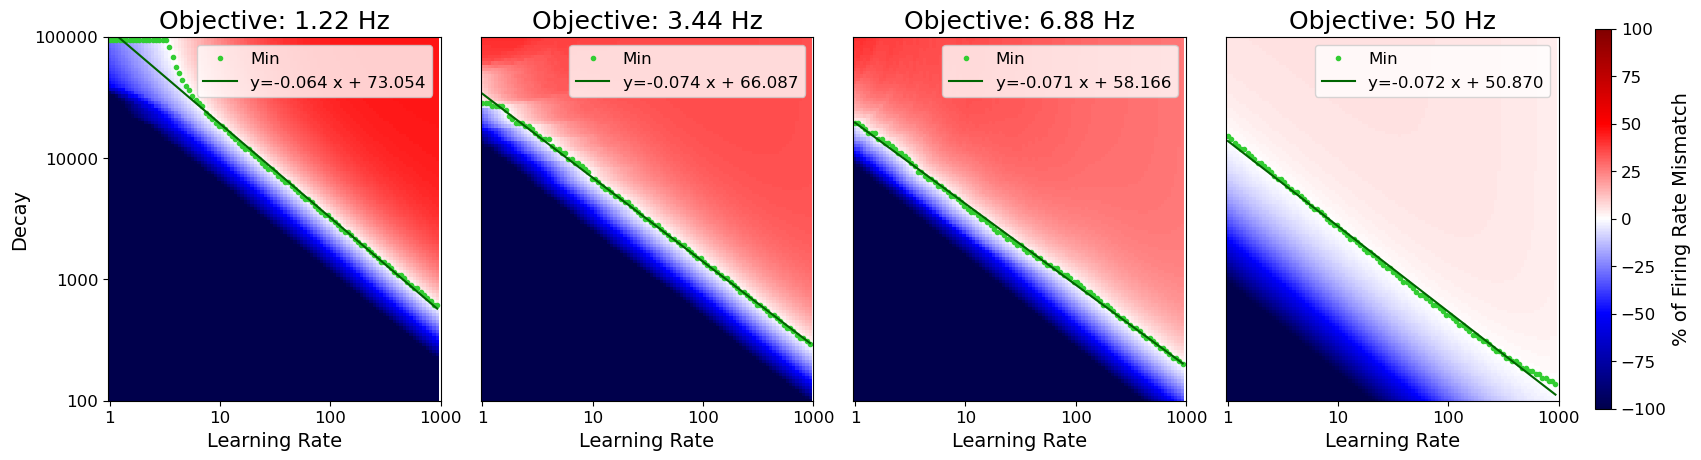

In [44]:
# Plotting Average over G
figname = 'FIG_2_A'
fig = plt.figure(figsize=(16, 10))

# Create a variable to hold the last imshow object for colorbar association
last_imshow = None

for o in range(nobjs):
    # Average over G
    ax = plt.subplot(1, nobjs, o + 1)
    last_imshow = plt.imshow(100 * mean_hom_fit[o] / obj_rates[o], vmin=-100, vmax=100, cmap='seismic', 
                             origin='lower', interpolation='none')
    plt.plot(range(0, nlr), min_mm_pos[o], '.', label='Min', color='limegreen')
    plt.plot(range(0, nlr), fit_res_2plot[o][0] * range(0, nlr) + fit_res_2plot[o][1], '-', 
             color='darkgreen',
             label='y=' + "{:.3f}".format(fit_res[o][0]) + ' x + ' + "{:.3f}".format(fit_res[o][1]))        
    
    plt.xticks(ticks=np.linspace(0, nlr, 4), labels=lr_labels, fontsize=TICKS)
    plt.xlabel('Learning Rate', fontsize=LABEL)
    plt.title('Objective: ' + str(obj_rates[o]) + ' Hz', fontsize=TITLE)
    plt.ylim([0, ndec])
    plt.legend(fontsize=LEGEND)
    
    if o == 0:
        plt.yticks(ticks=np.linspace(0, ndec, 4), labels=dec_labels, fontsize=TICKS)   
        plt.ylabel('Decay', fontsize=LABEL)
    else:
        plt.yticks(ticks=[])

plt.tight_layout()

# Colorbar
cbar_ax = fig.add_axes([1, 0.31, 0.01, 0.38])
cbar = plt.colorbar(last_imshow, cax=cbar_ax)  # Explicitly link to the last imshow object
cbar.set_label('% of Firing Rate Mismatch', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)  # Colorbar ticks fontsize

plt.show()

# Save the figure
fig.savefig(figfold + figname + '.png', dpi=300, bbox_inches='tight')  # Ensure tight bounding box
fig.savefig(figfold + figname + '.svg', bbox_inches='tight')  # Ensure tight bounding box


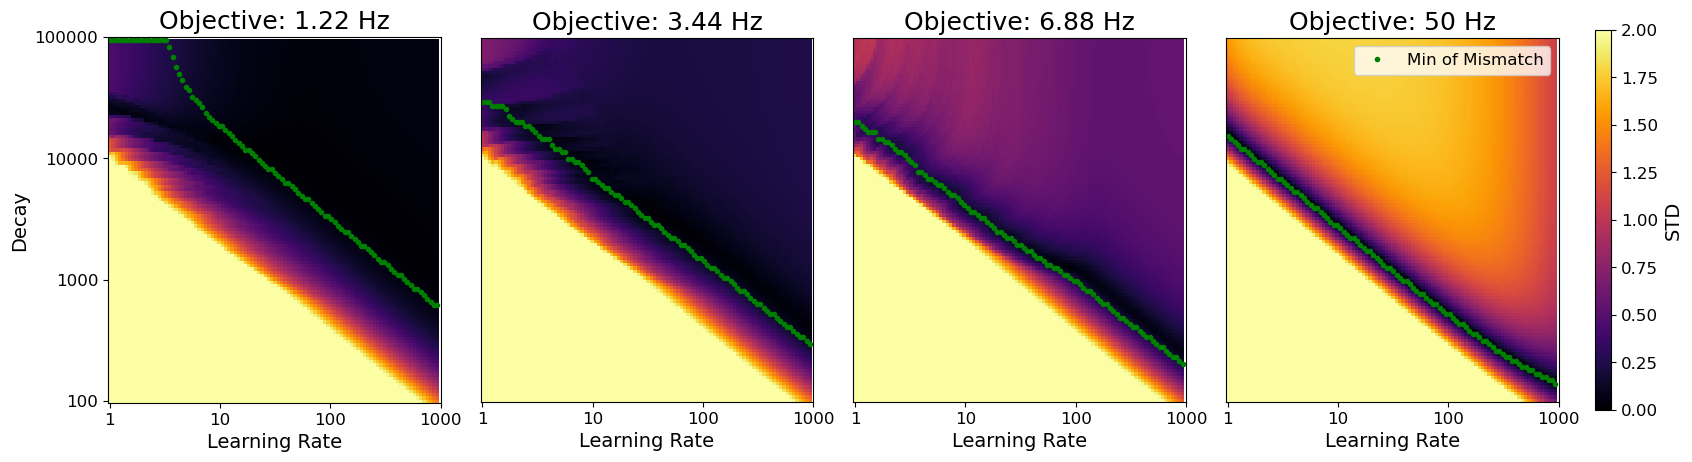

In [45]:
# Plotting STD
figname = 'FIG_2_B'
fig = plt.figure(figsize=(16, 10))

# Create a variable to hold the last imshow object for colorbar association
last_imshow = None

for o in range(nobjs):
    # STD over G
    ax = plt.subplot(1, nobjs, o + 1)
    last_imshow = plt.imshow(std_hom_fit[o], vmin=0, vmax=2, cmap='inferno', origin='lower', interpolation='none')
    plt.plot(range(0, nlr), min_mm_pos[o], 'g.', label='Min of Mismatch')
    
    plt.xticks(ticks=np.linspace(0, nlr, 4), labels=lr_labels, fontsize=TICKS)
    plt.xlabel('Learning Rate', fontsize=LABEL)
    plt.title('Objective: ' + str(obj_rates[o]) + ' Hz', fontsize=TITLE)
    
    if o == 0:
        plt.yticks(ticks=np.linspace(0, ndec, 4), labels=dec_labels, fontsize=TICKS)
        plt.ylabel('Decay', fontsize=LABEL)
    else:
        plt.yticks(ticks=[])
        
plt.legend(fontsize=LEGEND)
plt.tight_layout()

# Colorbar
cbar_ax2 = fig.add_axes([1, 0.31, 0.01, 0.38])
cbar2 = plt.colorbar(last_imshow, cax=cbar_ax2)  # Explicitly link to the last imshow object
cbar2.set_label('STD', fontsize=COLORBAR)
cbar2.ax.tick_params(labelsize=TICKS)  # Adjust colorbar tick font size

plt.show()

# Save the figure
fig.savefig(figfold + figname + '.png', dpi=300, bbox_inches='tight')  # Ensure tight bounding box
fig.savefig(figfold + figname + '.svg', bbox_inches='tight')  # Ensure tight bounding box


## FIC vs STR grid

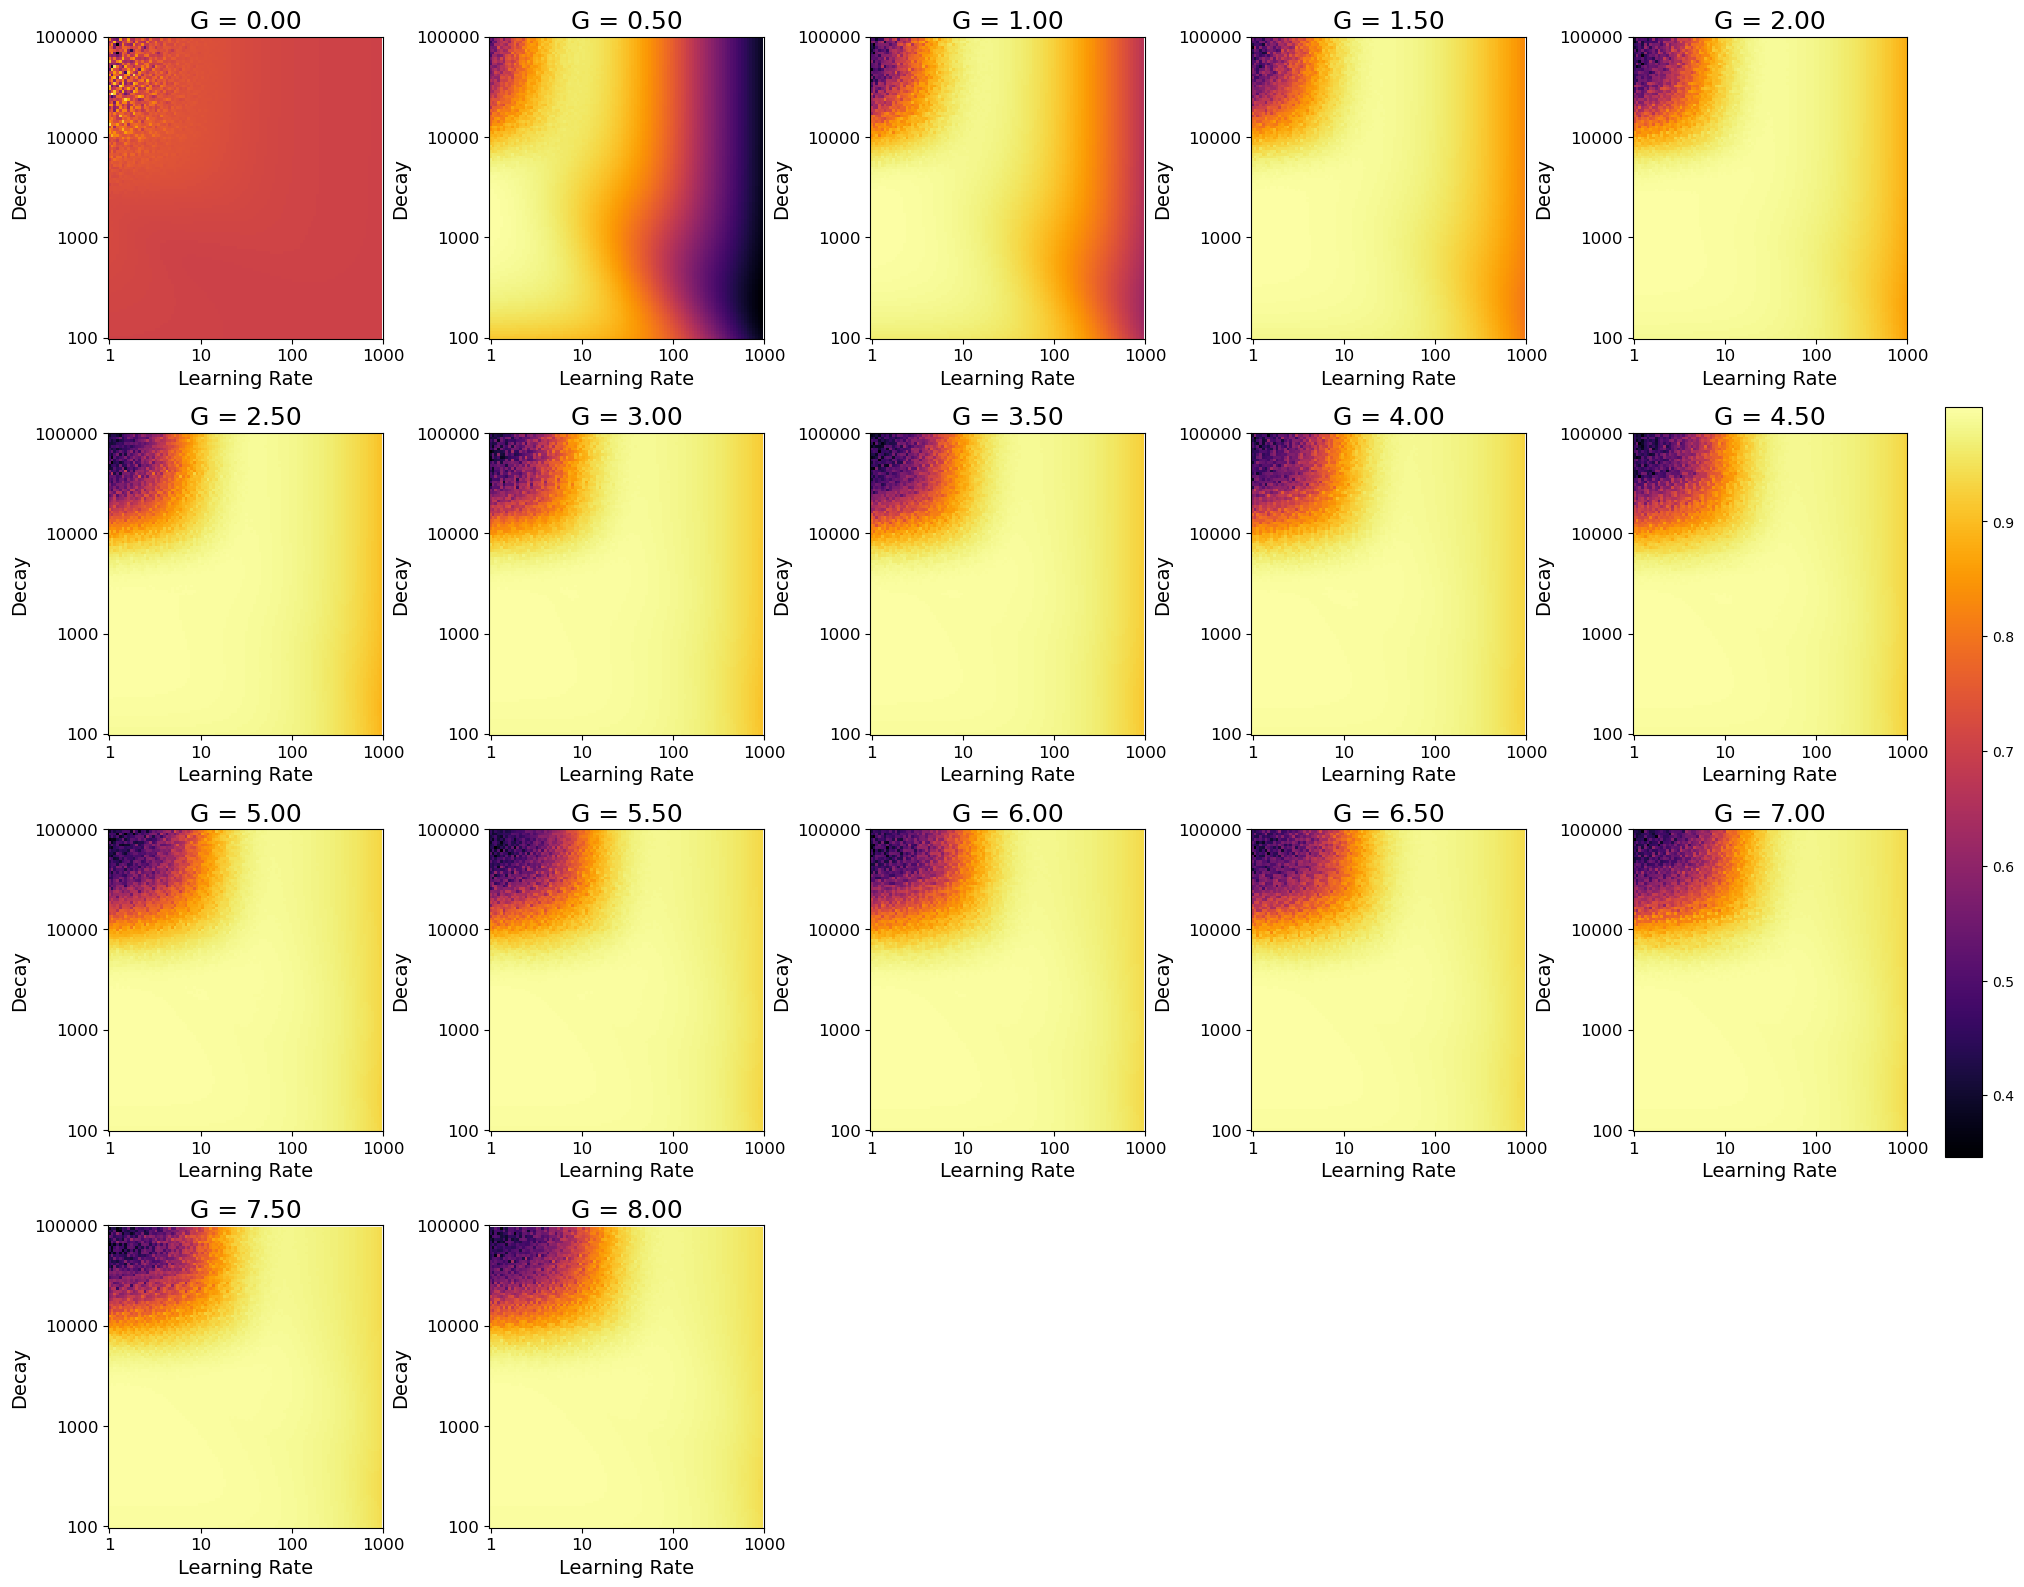

In [7]:
# Plot 17 subplots where you show a heatmap of the average accross the last dimension
figname = 'Supp_fig_1'
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()
G_values = np.arange(0, 8.5, 0.5)
for i in range(17):
    ax = axes[i]
    heatmap_data = np.mean(fic_corr[:, :, :, i, :], axis=3)
    im = ax.imshow(heatmap_data, cmap='inferno', origin='lower', interpolation='none')
    ax.set_title(f'G = {G_values[i]:.2f}', fontsize=TITLE)
    ax.set_xticks(np.linspace(0, nlr, 4))
    ax.set_xticklabels(lr_labels, fontsize=TICKS)
    ax.set_xlabel('Learning Rate', fontsize=LABEL)
    ax.set_yticks(np.linspace(0, ndec, 4))
    ax.set_yticklabels(dec_labels, fontsize=TICKS)
    ax.set_ylabel('Decay', fontsize=LABEL)

# Hide any unused subplots
for j in range(17, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
plt.show()

# Save the figure
#fig.savefig(figfold + figname + '.png', dpi=300)
#fig.savefig(figfold + figname + '.svg')

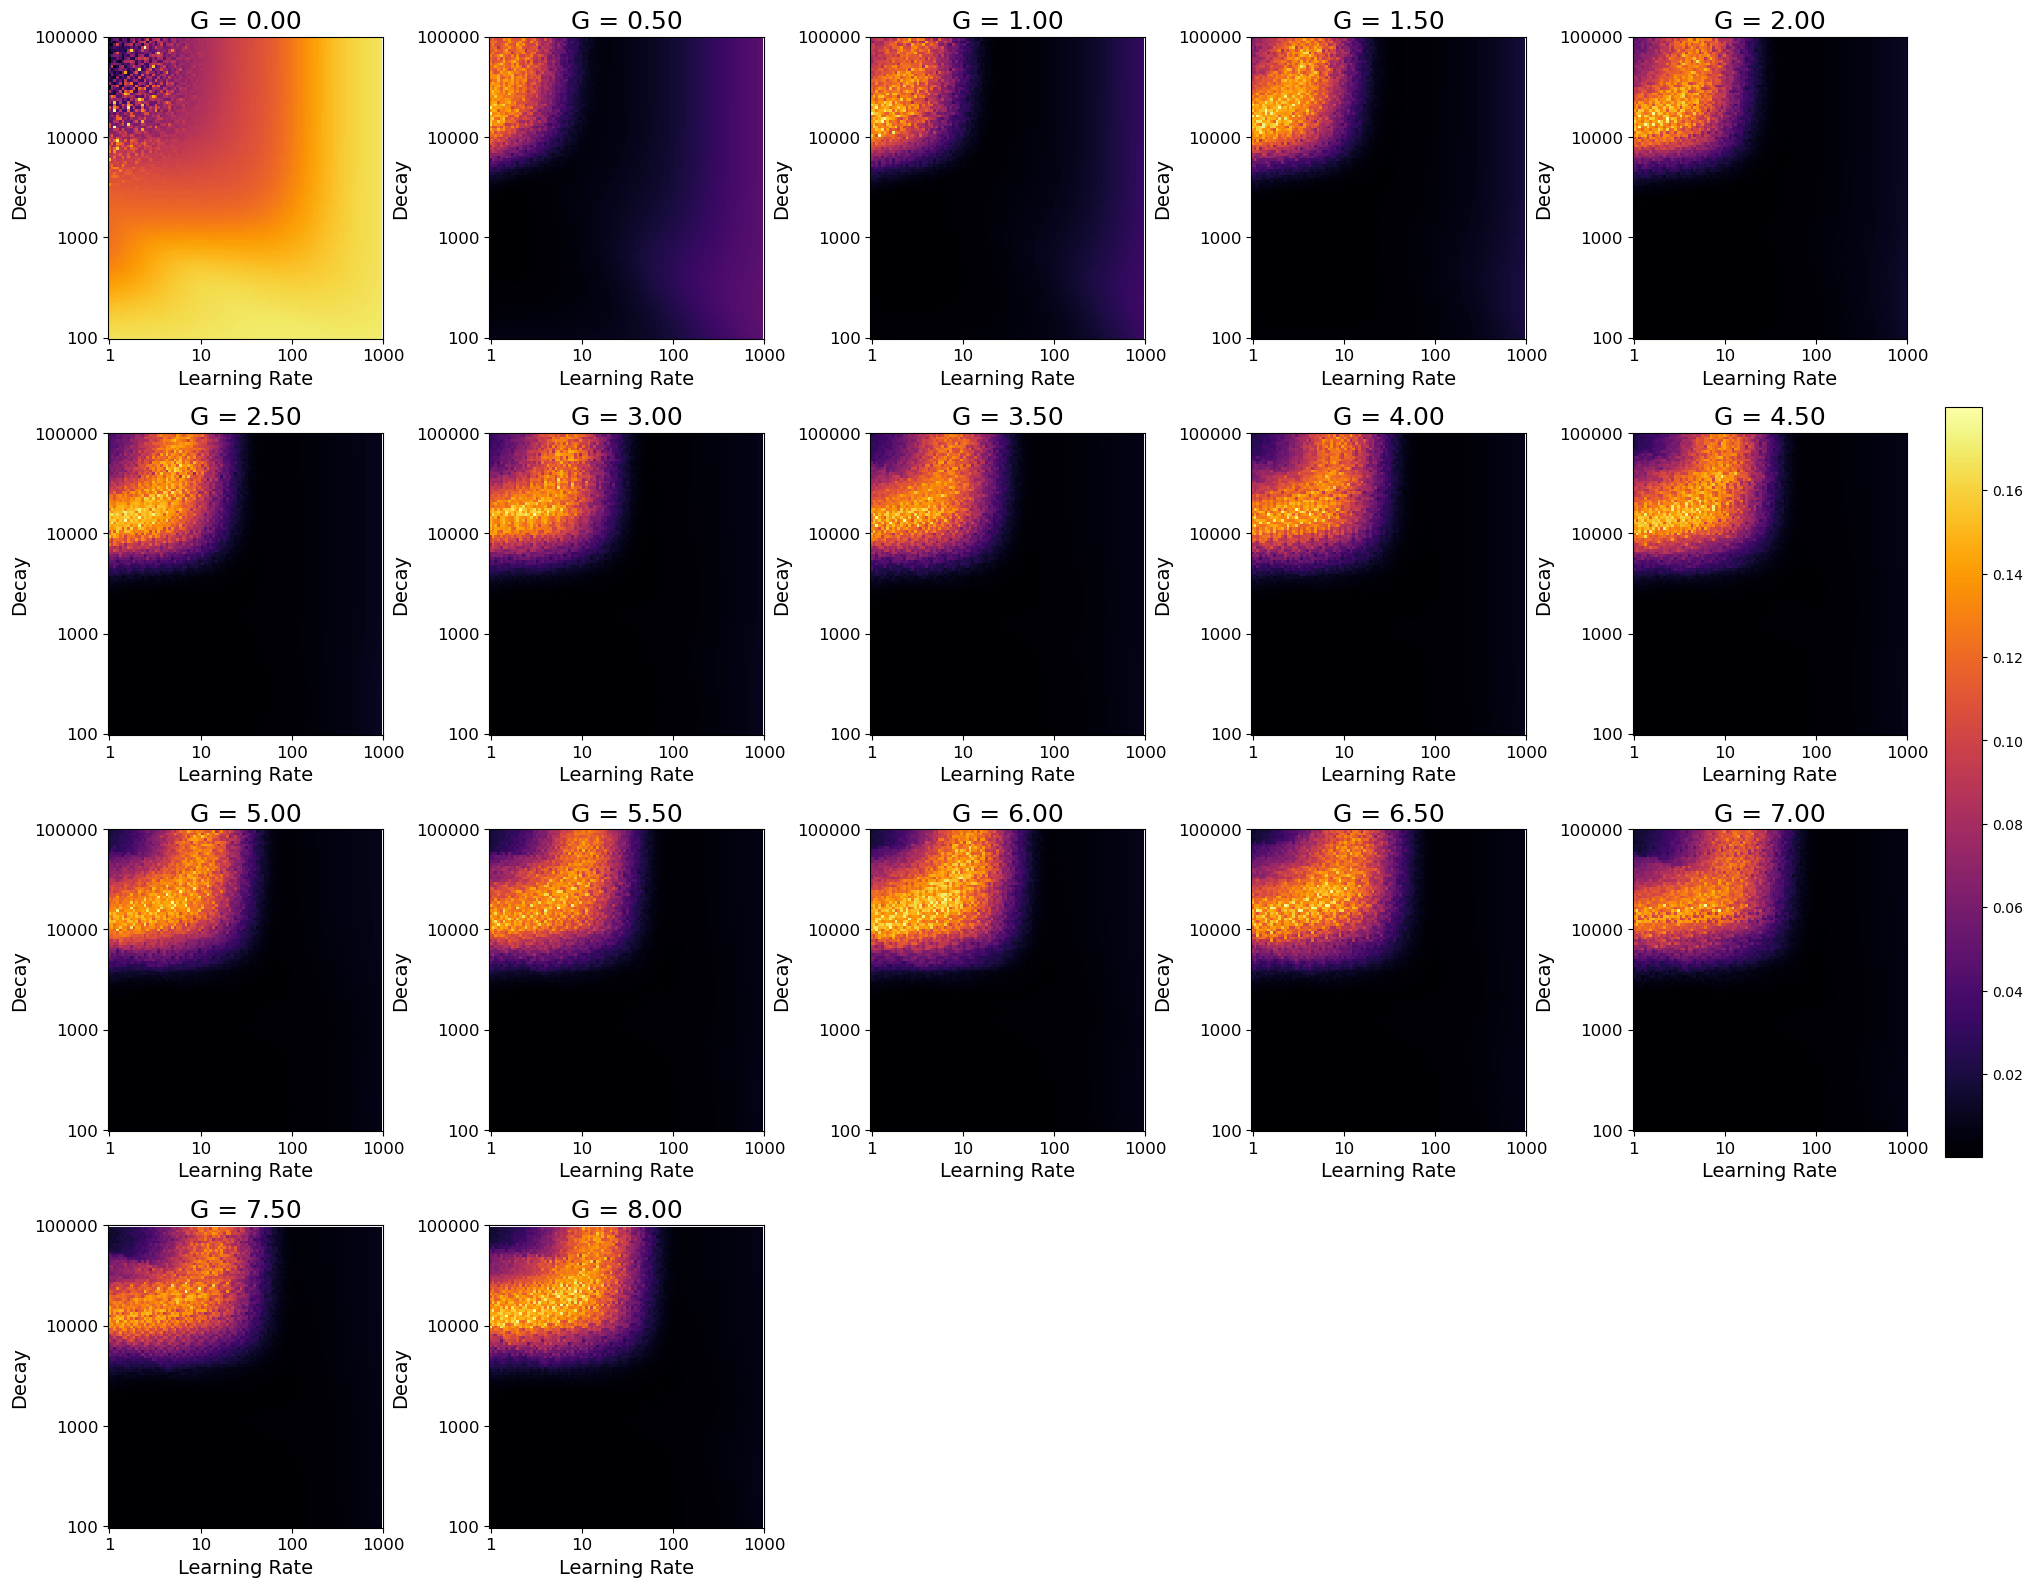

In [8]:
# Plot 17 subplots where you show a heatmap of the average accross the last dimension
figname = 'Supp_fig_2'
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()
G_values = np.arange(0, 8.5, 0.5)
for i in range(17):
    ax = axes[i]
    #heatmap_data = np.mean(fic_corr[:, :, :, i, :], axis=3)
    # Create a heatmap with the index it takes to reach the maximum value
    heatmap_data = np.std(fic_corr[:, :, :, i, :], axis=3)
    im = ax.imshow(heatmap_data, cmap='inferno', origin='lower', interpolation='none')
    ax.set_title(f'G = {G_values[i]:.2f}', fontsize=TITLE)
    ax.set_xticks(np.linspace(0, nlr, 4))
    ax.set_xticklabels(lr_labels, fontsize=TICKS)
    ax.set_xlabel('Learning Rate', fontsize=LABEL)
    ax.set_yticks(np.linspace(0, ndec, 4))
    ax.set_yticklabels(dec_labels, fontsize=TICKS)
    ax.set_ylabel('Decay', fontsize=LABEL)

# Hide any unused subplots
for j in range(17, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
plt.show()

# Save the figure
#fig.savefig(figfold + figname + '.png', dpi=300)
#fig.savefig(figfold + figname + '.svg')

#### Comparison of static vs dynamic FIC



Acá falta agregar los paneles con correlación con la strength y la MSE.

También falta agregar en el primer panel el modelo estático que usar el promedio del FIC dinámico (mixed).


Hacer los gráficos usando el promedio de varias simulaciones para asegurarse que la inestabilidad del mixed es observada para diferentes codiciones iniciales.

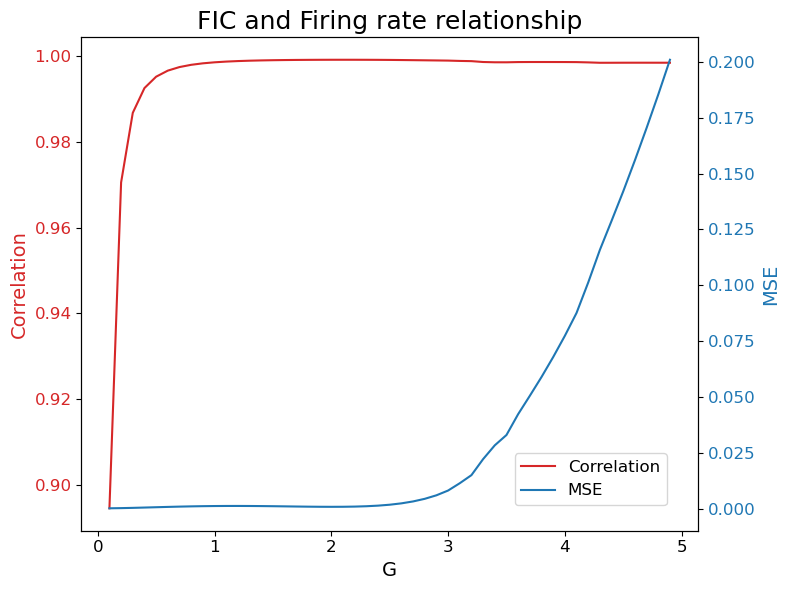

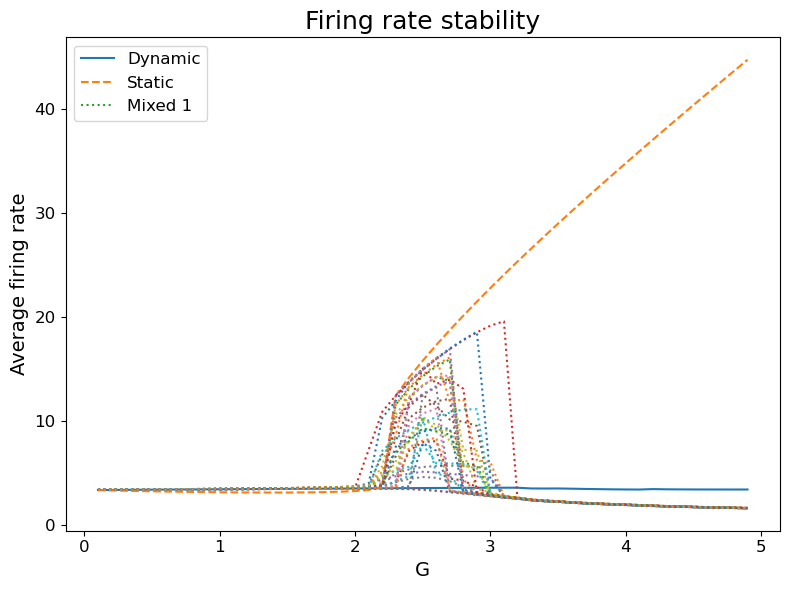

In [63]:
import numpy as np

# Define the data path
data_path = "/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar"

# Load the results from the specified directory
mse_values = np.load(os.path.join(data_path, "mse_values.npy"))
corr_values = np.load(os.path.join(data_path, "corr_values.npy"))
avg_fr_dyn_values = np.load(os.path.join(data_path, "avg_fr_dyn_values.npy"))
avg_fr_stat_values = np.load(os.path.join(data_path, "avg_fr_stat_values.npy"))
avg_fr_mixed_values = np.load(os.path.join(data_path, "avg_fr_mixed_values.npy"))
stat_fic_values = np.load(os.path.join(data_path, "stat_fic_values.npy"))
dyn_fic_values = np.load(os.path.join(data_path, "dyn_fic_values.npy"))
G_values = np.load(os.path.join(data_path, "G_values.npy"))

# Panel 2_D: Shared y-axis plot for Correlation and MSE
fig, ax1 = plt.subplots(figsize=(8,6))

# Correlation (Left y-axis)
color = 'tab:red'
ax1.set_xlabel('G', fontsize=LABEL)
ax1.set_ylabel('Correlation', color=color, fontsize=LABEL)
ax1.plot(G_values, corr_values, color=color, label='Correlation')
ax1.tick_params(axis='y', labelcolor=color, labelsize=TICKS)
ax1.tick_params(axis='x', labelsize=TICKS)

# MSE (Right y-axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('MSE', color=color, fontsize=LABEL)
ax2.plot(G_values, mse_values, color=color, label='MSE')
ax2.tick_params(axis='y', labelcolor=color, labelsize=TICKS)


# Add legends for clarity
fig.legend(bbox_to_anchor=(0.85, 0.25), fontsize=LEGEND)

plt.title('FIC and Firing rate relationship', fontsize=TITLE)
fig.tight_layout()  # Adjust layout to avoid clipping
plt.savefig(figfold + 'FIG_2_D.png', dpi=300)
plt.savefig(figfold + 'FIG_2_D.svg')
plt.show()

# Panel 2_E: Average firing rates for dynamic, static, and mixed simulations
plt.figure(figsize=(8,6))

plt.plot(G_values, np.mean(avg_fr_dyn_values, axis=1), label='Dynamic')
plt.plot(G_values, np.mean(avg_fr_stat_values, axis=1), '--', label='Static')

# Loop for mixed values
for i in range(avg_fr_mixed_values.shape[0]):
    mix_rep = np.mean(avg_fr_mixed_values[i, :, :], axis=1)
    plt.plot(G_values, mix_rep, ':', label=f'Mixed {i+1}' if i == 0 else "")

plt.xlabel('G', fontsize=LABEL)
plt.ylabel('Average firing rate', fontsize=LABEL)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.title('Firing rate stability', fontsize=TITLE)
plt.legend(fontsize=LEGEND)
plt.tight_layout()
plt.savefig(figfold + 'FIG_2_C.png', dpi=300)
plt.savefig(figfold + 'FIG_2_C.svg')
plt.show()


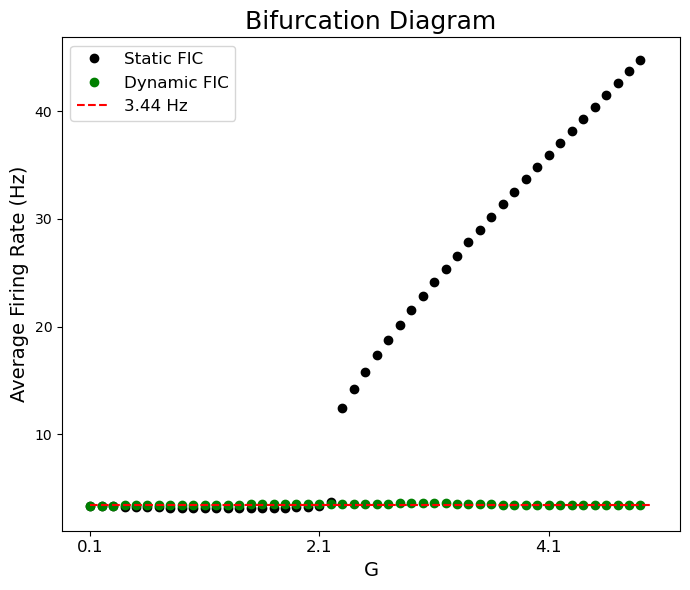

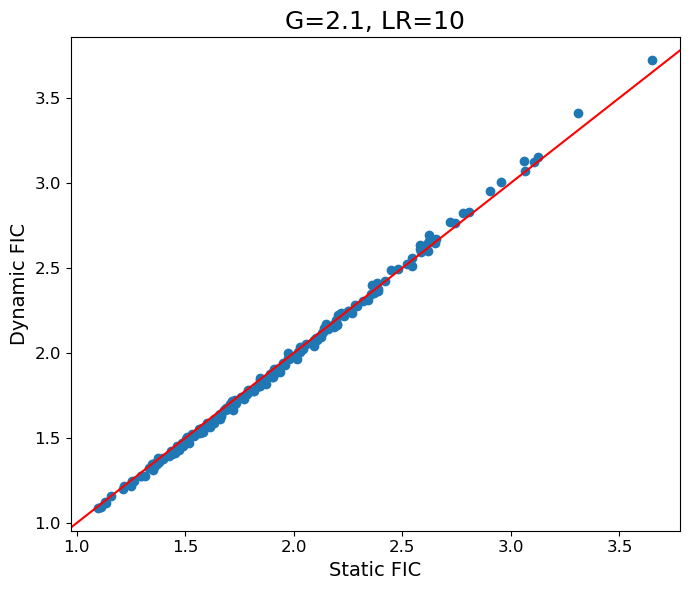

In [10]:
# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

# Plotting FR vs G (Bifurcation diagram) - Separate into two independent figures
G_range = G_values
figname = 'Supp_fig_3'

# First Figure: Bifurcation Diagram
fig1 = plt.figure(figsize=(7, 6))
plt.plot(np.mean(avg_fr_stat_values, axis=1), 'o', color='k', label='Static FIC', alpha=1)
plt.plot(np.mean(avg_fr_dyn_values, axis=1), 'o', color='g', label='Dynamic FIC', alpha=1)
plt.plot([0, len(G_range)], [3.44, 3.44], 'r--', label='3.44 Hz')

xtick_positions = range(0, len(G_range), 20)
plt.xticks(ticks=xtick_positions, labels=[f"{G_range[i]:.1f}" for i in xtick_positions], fontsize=TICKS)
plt.xlabel("G", fontsize=LABEL)
plt.ylabel("Average Firing Rate (Hz)", fontsize=LABEL)
plt.title("Bifurcation Diagram", fontsize=TITLE)
plt.legend(fontsize=LEGEND)
plt.tight_layout()
plt.show()

# Save First Figure
fig1.savefig(figfold + figname + '_bifurcation.svg', dpi=300)
fig1.savefig(figfold + figname + '_bifurcation.svg', dpi=300)

# Second Figure: Static vs Dynamic FIC
fig2 = plt.figure(figsize=(7, 6))
plt.plot(stat_fic_values[20], dyn_fic_values[20], 'o')
plt.axline((1.5, 1.5), slope=1, color='red')
plt.xlabel('Static FIC', fontsize=LABEL)
plt.ylabel('Dynamic FIC', fontsize=LABEL)
plt.title('G=2.1, LR=10', fontsize=TITLE)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.tight_layout()
plt.show()

# Save Second Figure
fig2.savefig(figfold + figname + '_static_vs_dynamic.svg', dpi=300)
fig2.savefig(figfold + figname + '_static_vs_dynamic.svg', dpi=300)


#### Neuromodulation with and without plasticity rule

In [65]:

# Neuromodulation
nm_mean_fr = [] # 0 is static, 1 dynamic
nm_std_fr = [] # 0 is static, 1 dynamic
nm_fc = [] # 0 is static, 1 dynamic
nm_fcd = [] # 0 is static, 1 dynamic
nm_mean_fr.append(np.load(datafolder+'neuromod/static5HT2a/mean_fr_grid.npy'))
nm_mean_fr.append(np.load(datafolder+'neuromod/dynamic5HT2a/mean_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/static5HT2a/std_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/dynamic5HT2a/std_fr_grid.npy'))

In [66]:
## Computing the correlation between receptor density and firing rates for each learning rate
LR_range = np.logspace(0,2.46,10)
#RECEPTORS = np.load("./data/Schaeffer200-Tian/D2_fallypride_hc49_jaworska_schaeffer200.npy")[:200]
#RECEPTORS = np.load("./data/Schaeffer200-Tian/NMDA_ge179_hc29_galovic_schaeffer200.npy")[:200]
RECEPTORS = np.load("./data/Schaeffer200-Tian/5HT2a_cimbi_hc29_beliveau_schaeffer200.npy")[:200]

RECEPTORS = RECEPTORS/max(RECEPTORS)-min(RECEPTORS)
RECEPTORS = RECEPTORS - max(RECEPTORS) + 1
receptors = np.reshape(RECEPTORS, (RECEPTORS.shape[0],1))
nlrs = 10
polyfit_out_static = [np.polyfit(np.squeeze(receptors), nm_mean_fr[0][x].T, 1, full=True) for x in range(nlrs)]
polyfit_out_dyn = [np.polyfit(np.squeeze(receptors), nm_mean_fr[1][x].T, 1, full=True) for x in range(nlrs)]
corr_out_static = [1-cdist(receptors.T, nm_mean_fr[0][x],metric='correlation') for x in range(nlrs)]
corr_out_dyn = [1-cdist(receptors.T, nm_mean_fr[1][x],metric='correlation') for x in range(nlrs)]

slope_rec_fr = [np.vstack([x[0][0],y[0][0]]) for x,y in zip(polyfit_out_static,polyfit_out_dyn)]
res_rec_fr = [np.vstack([x[0][1],y[0][1]]) for x,y in zip(polyfit_out_static,polyfit_out_dyn)]
corr_rec_fr = [np.vstack([x,y]) for x,y in zip(corr_out_static,corr_out_dyn)]


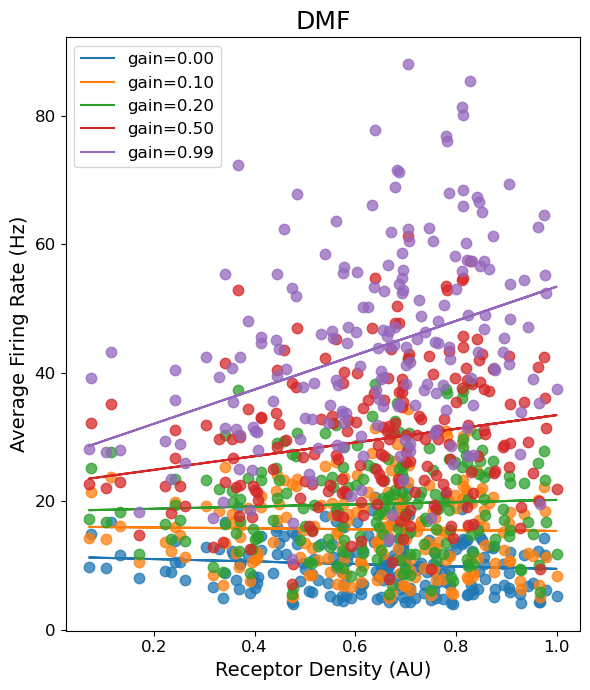

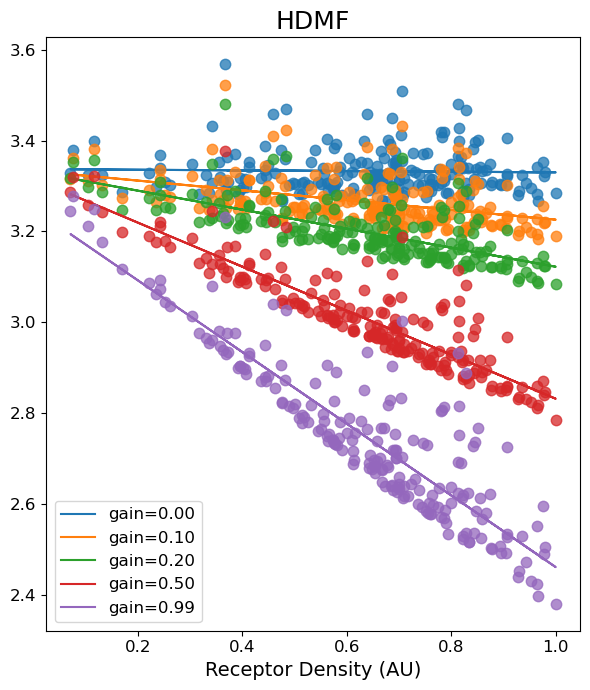

In [70]:

# Parameters
titles = ['DMF', 'HDMF']
lr_vals = np.logspace(0, 2.46, 10)
alpha_vals = [0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05]
receptors = RECEPTORS
gains2plot = [0, 10, 20, 50, 99]
nm_2_plot = [6, 8]
figname = 'FIG_4'

# Figure 1: DMF
fig1 = plt.figure(figsize=(6, 7))
for g in gains2plot:
    # Scatter plot
    plot, = plt.plot(receptors, nm_mean_fr[0][nm_2_plot[0], g, :], '.', markersize=15, alpha=0.75)
    
    # Compute and plot the linear fit
    coeffs = np.polyfit(np.squeeze(receptors), nm_mean_fr[0][nm_2_plot[0], g, :], 1)
    linear_fit = np.poly1d(coeffs)
    plt.plot(receptors, linear_fit(receptors), '-', color=plot.get_color(), 
             label=f'gain={g/100:.2f}')

plt.xlabel('Receptor Density (AU)', fontsize=LABEL)
plt.ylabel('Average Firing Rate (Hz)', fontsize=LABEL)
plt.title(titles[0], fontsize=TITLE)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.legend(fontsize=LEGEND)
plt.tight_layout()
plt.show()

# Save FIG_3A
fig1.savefig(figfold + figname + '_A.png', dpi=300)
fig1.savefig(figfold + figname + '_A.svg', dpi=300)

# Figure 2: HDMF
fig2 = plt.figure(figsize=(6, 7))
for g in gains2plot:
    # Scatter plot
    plot, = plt.plot(receptors, nm_mean_fr[1][nm_2_plot[1], g, :], '.', markersize=15, alpha=0.75)
    
    # Compute and plot the linear fit
    coeffs = np.polyfit(np.squeeze(receptors), nm_mean_fr[1][nm_2_plot[1], g, :], 1)
    linear_fit = np.poly1d(coeffs)
    plt.plot(receptors, linear_fit(receptors), '-', color=plot.get_color(), 
             label=f'gain={g/100:.2f}')

plt.xlabel('Receptor Density (AU)', fontsize=LABEL)
plt.title(titles[1], fontsize=TITLE)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.legend(fontsize=LEGEND)
plt.tight_layout()
plt.show()

# Save FIG_3B
fig2.savefig(figfold + figname + '_B.png', dpi=300)
fig2.savefig(figfold + figname + '_B.svg', dpi=300)

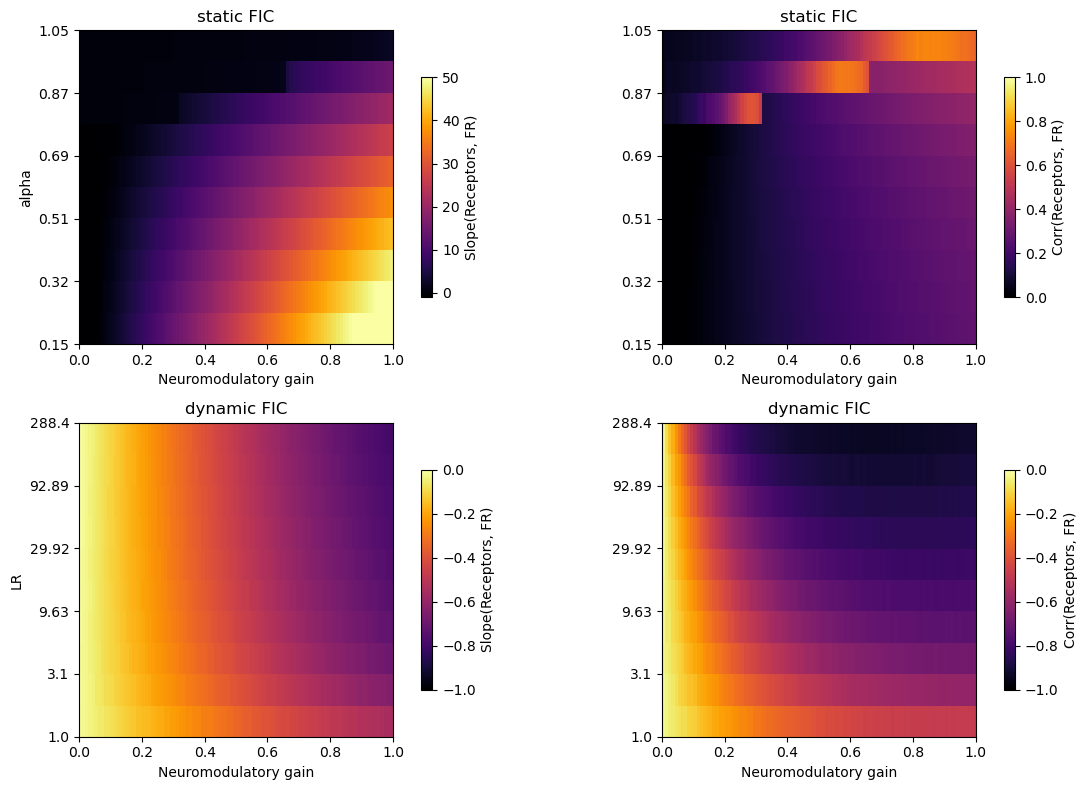

In [27]:
# LR vs Correlation
# LR_range = np.logspace(0,2.46,10)
# ,extent=(xmin,xmax,ymin,ymax))
titles = ['static FIC', 'dynamic FIC']
yticks = [np.floor(np.linspace(0.15, 1.05, 6)*100)/100, np.floor((np.logspace(0,2.46,6))*100)/100]
ylabel = ['alpha', 'LR']
slope_rec_fr_rs = np.dstack((slope_rec_fr))
res_rec_fr_rs = np.dstack((res_rec_fr))
corr_rec_fr_rs = np.dstack((corr_rec_fr))


s_vmin = [-1, -1]
s_vmax = [50, 0]
r_vmin = [0, 2.9]
r_vmax = [50, 3.3]
c_vmin = [0,-1]
c_vmax = [1,0]
figname = 'Supp_Fig_4'
fig = plt.figure(figsize=(12, 8))
cont = 1

for p in range(2):
    # Slope
    plt.subplot(2,2,cont)
    plt.imshow(slope_rec_fr_rs[p,:,:].T,origin='lower', 
               vmin=s_vmin[p], vmax=s_vmax[p], cmap='inferno', interpolation='none', extent=(0,100,0,100))
    plt.title(titles[p])
    plt.colorbar(label='Slope(Receptors, FR)',shrink=0.7)    
    plt.yticks(ticks=np.linspace(0,100,6), labels=yticks[p])
    plt.ylabel(ylabel[p])
    plt.xticks(ticks=np.linspace(0,100,6), labels=np.linspace(0,100,6)/100)
    plt.xlabel('Neuromodulatory gain') 

    # Correlation
    plt.subplot(2,2,cont+1)
    plt.imshow(corr_rec_fr_rs[p,:,:].T,origin='lower', 
               vmin=c_vmin[p], vmax=c_vmax[p], cmap='inferno', interpolation='none', extent=(0,100,0,100))
    plt.title(titles[p])
    plt.colorbar(label='Corr(Receptors, FR)',shrink=0.7)    
    plt.yticks(ticks=np.linspace(0,100,6), labels=yticks[p])
    plt.xticks(ticks=np.linspace(0,100,6), labels=np.linspace(0,100,6)/100)
    plt.xlabel('Neuromodulatory gain') 
    # plt.ylabel(ylabel[p])

    cont=3
    


plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.svg')

### II.- Fitting to fMRI

In [32]:
import fastdyn_fic_dmf as dmf

def compute_fcd(data, wsize, overlap, isubdiag, params):
    T, N = data.shape
    win_start = np.arange(0, T - params["wsize"] - 1, params["wsize"] - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + params["wsize"] + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0], isubdiag[1]]
    return fcd

C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2 * C / np.max(C)
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
isubfcd = np.triu_indices(C.shape[1], 1)
burnout = 7
params["wsize"] = 30
overlap = 29
params['TR'] = 2
T = 250
params['dtt'] = 0.001  # Assuming 'dtt' is defined; adjust as needed
nb_steps = int(T * params['TR'] / params['dtt'])
win_start = np.arange(0, T - burnout - params["wsize"], params["wsize"] - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])

emp_data = mat73.loadmat('data/BOLD_timeseries_Awake.mat')
emp_data = np.squeeze(np.array(emp_data['BOLD_timeseries_Awake']))[:,:200,:]
emp_data = emp_data[:,:,burnout:]


emp_fcds = []
for sub in range(emp_data.shape[0]):
    fcds = compute_fcd(emp_data[sub, :, :].T, params["wsize"], overlap, isubfcd, params)
    upp_tr_fcd = np.corrcoef(fcds.T)[np.triu_indices(nwins-1, 1)]
    emp_fcds.append(upp_tr_fcd)

emp_fc = np.mean(np.array([np.corrcoef(emp_data[sub, :, :]) for sub in range(emp_data.shape[0])]), axis=0)
emp_fcds = np.hstack((emp_fcds))


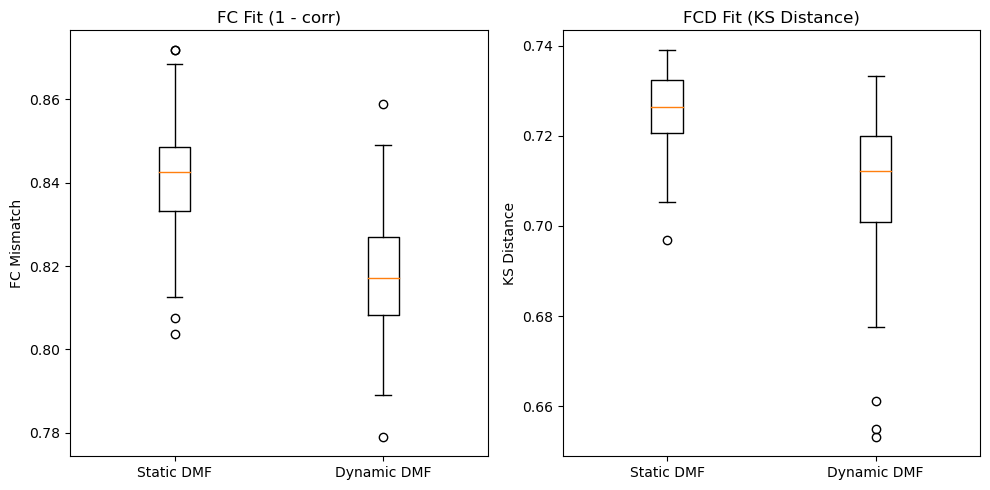

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ks_2samp

# ------------------------------------------------------------------
# 1) LOAD THE DATA
# ------------------------------------------------------------------
datafolder = '/home/ivan.mindlin/Desktop/DatosParaRuben/'

# fcs_grid.shape == (2, 100, 200, 200)
#   - axis 0 => 0 for static DMF, 1 for dynamic DMF
#   - axis 1 => 100 simulation repetitions
#   - axis 2,3 => 200 x 200 FC matrices
fcs_grid = np.load(datafolder + 'FittedSimulations/fcs_grid.npy')

# fcds_grid.shape == (2, 100, 212, 212)
#   - axis 0 => 0 for static DMF, 1 for dynamic DMF
#   - axis 1 => 100 simulation repetitions
#   - axis 2,3 => 212 x 212 FCD matrices
fcds_grid = np.load(datafolder + 'FittedSimulations/fcds_grid.npy')

# ------------------------------------------------------------------
# 2) HELPER FUNCTIONS
# ------------------------------------------------------------------

def upper_triangular_flat(mat):
    """
    Return the flattened upper triangular (off-diagonal) elements of a square matrix.
    """
    # np.triu_indices excludes the diagonal if we pass k=1
    triu_idx = np.triu_indices(mat.shape[0], k=1)
    return mat[triu_idx]

def fc_fit_metric(emp_fc, sim_fc):
    """
    Compute 1 - Pearson correlation for the upper-triangular (off-diagonal) entries.
    """
    emp_vals = upper_triangular_flat(emp_fc)
    sim_vals = upper_triangular_flat(sim_fc)
    # Handle potential zero-variance corner cases:
    if np.std(emp_vals) == 0 or np.std(sim_vals) == 0:
        return 1.0  # If there's no variance, treat as worst-case mismatch
    
    corr, _ = pearsonr(emp_vals, sim_vals)
    return 1.0 - corr

def fcd_fit_metric(emp_fcds, sim_fcd):
    """
    Compute the average KS distance between the simulated FCD distribution
    and each subject's empirical FCD distribution, using only the
    upper triangular (off-diagonal) entries.
    """
    sim_vals = upper_triangular_flat(sim_fcd)
            
    # Compute KS distance
    D, _ = ks_2samp(emp_fcds, sim_vals)        
    return D

# ------------------------------------------------------------------
# 3) COMPUTE THE METRICS ACROSS REPEATS
# ------------------------------------------------------------------
n_reps = fcs_grid.shape[1]  # 100

# Prepare arrays to hold the fit metrics
fc_fits_static = []
fc_fits_dynamic = []
fcd_fits_static = []
fcd_fits_dynamic = []

for rep in range(n_reps):
    # ---------------------
    # FC Fit
    # ---------------------
    sim_fc_static = fcs_grid[0, rep, :, :]
    sim_fc_dynamic = fcs_grid[1, rep, :, :]
    
    fc_fits_static.append(fc_fit_metric(emp_fc, sim_fc_static))
    fc_fits_dynamic.append(fc_fit_metric(emp_fc, sim_fc_dynamic))
    
    # ---------------------
    # FCD Fit
    # ---------------------
    sim_fcd_static = fcds_grid[0, rep, :, :]
    sim_fcd_dynamic = fcds_grid[1, rep, :, :]
    
    fcd_fits_static.append(fcd_fit_metric(emp_fcds, sim_fcd_static))
    fcd_fits_dynamic.append(fcd_fit_metric(emp_fcds, sim_fcd_dynamic))

# Convert to numpy arrays for convenience
fc_fits_static = np.array(fc_fits_static)
fc_fits_dynamic = np.array(fc_fits_dynamic)
fcd_fits_static = np.array(fcd_fits_static)
fcd_fits_dynamic = np.array(fcd_fits_dynamic)

# ------------------------------------------------------------------
# 4) PLOT THE DISTRIBUTIONS OF THE FIT METRICS
# ------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# FC fit distribution
axes[0].boxplot([fc_fits_static, fc_fits_dynamic],
                labels=['Static DMF', 'Dynamic DMF'])
axes[0].set_title('FC Fit (1 - corr)')
axes[0].set_ylabel('FC Mismatch')

# FCD fit distribution
axes[1].boxplot([fcd_fits_static, fcd_fits_dynamic],
                labels=['Static DMF', 'Dynamic DMF'])
axes[1].set_title('FCD Fit (KS Distance)')
axes[1].set_ylabel('KS Distance')

plt.show()


In [31]:
# Loading data
# Homeostatic fit
#emp_data = loadmat(datafolder+'CNT_data.mat')
fc_fit = [] # 0=static, 1=dynamic
fcd_fit = [] # 0=static, 1=dynamic
fc_fit.append(loadmat(datafolder+'FitteoObservables/stat_fc.mat'))
fc_fit.append(loadmat(datafolder+'FitteoObservables/dyn_fc.mat'))

fcd_fit.append(loadmat(datafolder+'FitteoObservables/stat_fcd.mat'))
fcd_fit.append(loadmat(datafolder+'FitteoObservables/dyn_fcd.mat'))

# Repeated simulation at optima
fc_reps = np.load(datafolder+'RepeticionesSimulaciones/fcs_grid.npy')
fcd_reps = np.load(datafolder+'RepeticionesSimulaciones/fcds_grid.npy')





In [17]:
np.shape(fc_fit[0]['emp_fc'])
np.shape(fc_reps)

(2, 100, 90, 90)

In [18]:
# Extracting empirical FC and FCD
from scipy.stats import ks_2samp
emp_fcd = list()
nsubs = 13
fcd_dim = 78
fcd_triu_ids = np.triu_indices(fcd_dim,k=1)
for s in range(nsubs):
    aux = fcd_fit[0]['emp_fcd'][s,:,:]
    emp_fcd.append(aux[fcd_triu_ids])
    
emp_fcd = np.hstack((emp_fcd))


sim_fcd_stat = list()
sim_fcd_dyn = list()
nreps = 100
sim_fcd_dim = 154
sim_fcd_triu_ids = np.triu_indices(sim_fcd_dim,k=1)
rep_ks = np.zeros((2,nreps))
rep_corr = np.zeros((2,nreps))
fc_triu_ids = np.triu_indices(90,k=1)
emp_triu = fc_fit[0]['emp_fc'][fc_triu_ids]
for r in range(nreps):
    
    # Static FCD
    aux = fcd_reps[0,r,:,:]
    sim_fcd_stat.append(aux[sim_fcd_triu_ids])
    rep_ks[0,r] = ks_2samp(aux[sim_fcd_triu_ids],emp_fcd)[0]
    # Static FC    
    sim_triu = fc_reps[0,r,:,:]
    sim_triu = sim_triu[fc_triu_ids]
    aux = np.corrcoef(sim_triu,emp_triu)    
    rep_corr[0,r] = aux[0][1]
    # Dynamic FCD
    aux = fcd_reps[1,r,:,:]
    sim_fcd_dyn.append(aux[sim_fcd_triu_ids])
    rep_ks[1,r] = ks_2samp(aux[sim_fcd_triu_ids],emp_fcd)[0]
    # Dynamic FCD    
    sim_triu = fc_reps[1,r,:,:]
    sim_triu = sim_triu[fc_triu_ids]
    aux = np.corrcoef(sim_triu,emp_triu)    
    rep_corr[1,r] = aux[0][1]


sim_fcd_stat = np.hstack((sim_fcd_stat))
sim_fcd_dyn = np.hstack((sim_fcd_dyn))

## Computing ks for each repetition

In [19]:
# rep_corr

In [20]:
# np.shape(fcd_reps['emp_fcd'])
# fcd_fit
np.shape(emp_fcd)
np.shape(sim_fcd_dyn)
# rep_ks
col_pal = sns.color_palette()
col_pal

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

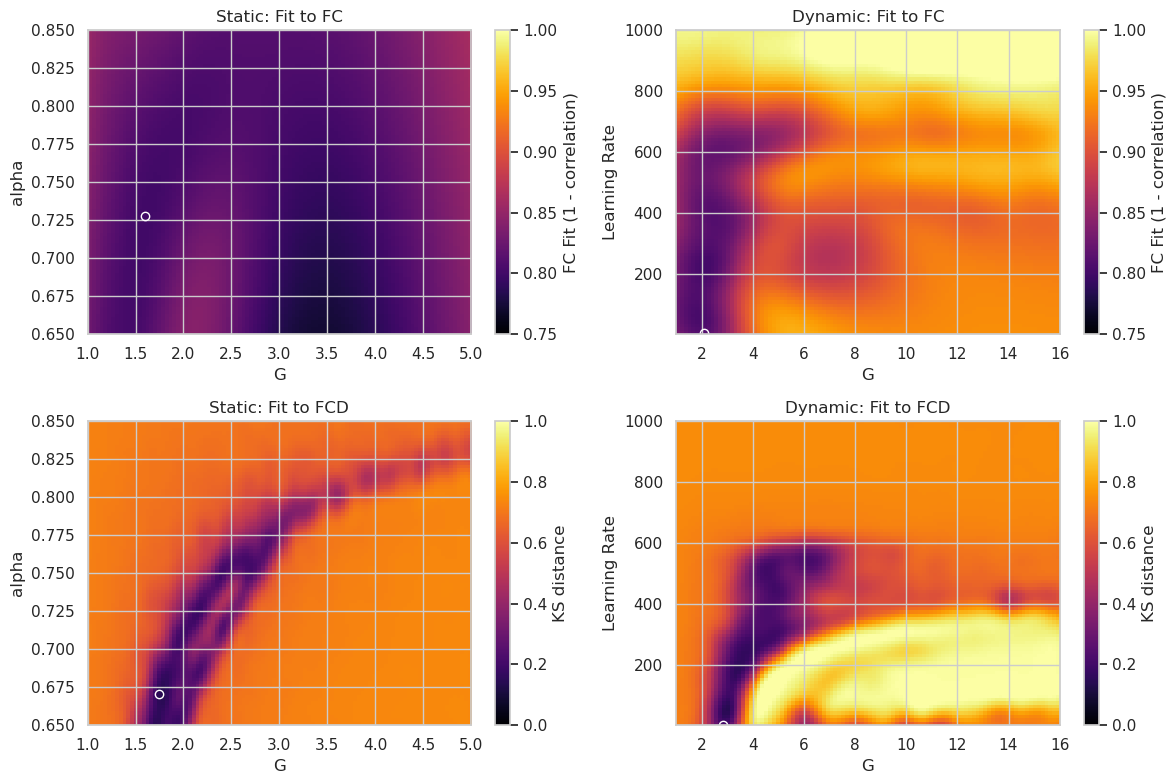

In [21]:
# Plotting output of bayesian optimization
figname = 'bayesian_op_output'

fc_stat_alpha_space = np.squeeze(fc_fit[0]['alpha_space'])
fc_stat_g_space = np.squeeze(fc_fit[0]['G_space'])
fc_dyn_lr_space = np.squeeze(fc_fit[1]['lr_space'])
fc_dyn_g_space = np.squeeze(fc_fit[1]['G_space'])

fcd_stat_alpha_space = np.squeeze(fc_fit[0]['alpha_space'])
fcd_stat_g_space = np.squeeze(fc_fit[0]['G_space'])
fcd_dyn_lr_space = np.squeeze(fc_fit[1]['lr_space'])
fcd_dyn_g_space = np.squeeze(fc_fit[1]['G_space'])


fig = plt.figure(figsize=(12, 8))
# STATIC FC FIT
plt.subplot(2,2,1)
plt.imshow(fc_fit[0]['funcEvals_stat'].T, cmap='inferno', 
           extent=(fc_stat_g_space[0], fc_stat_g_space[-1], fc_stat_alpha_space[0], fc_stat_alpha_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0.75, vmax=1)
plt.colorbar(label='FC Fit (1 - correlation)')
plt.ylabel('alpha')
plt.xlabel('G')
plt.plot(fc_fit[0]['G_stat_fc'],fc_fit[0]['alpha_stat_fc'],'o',color='w', markerfacecolor='None')
# plt.plot(fc_fit[0]['alpha_stat_fc'],fc_fit[0]['G_stat_fc'],'o',color='w', markerfacecolor='None')
plt.title('Static: Fit to FC')

# DYNAMIC FC FIT
plt.subplot(2,2,2)
plt.imshow(fc_fit[1]['funcEvals'].T, cmap='inferno', 
           extent=(fc_dyn_g_space[0], fc_dyn_g_space[-1], fc_dyn_lr_space[0], fc_dyn_lr_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0.75, vmax=1)
plt.colorbar(label='FC Fit (1 - correlation)')
plt.ylabel('Learning Rate')
plt.xlabel('G')
plt.plot(fc_fit[1]['G_dyn_fc'],fc_fit[1]['lr_dyn_fc'],'o',color='w', markerfacecolor='None')
plt.title('Dynamic: Fit to FC')

# STATIC FCD FIT
plt.subplot(2,2,3)
plt.imshow(fcd_fit[0]['funcEvals_stat'].T, cmap='inferno', 
           extent=(fcd_stat_g_space[0], fcd_stat_g_space[-1], fcd_stat_alpha_space[0], fcd_stat_alpha_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='KS distance')
plt.ylabel('alpha')
plt.xlabel('G')
plt.plot(fcd_fit[0]['G_stat_fcd'],fcd_fit[0]['alpha_stat_fcd'],'o',color='w', markerfacecolor='None')
plt.title('Static: Fit to FCD')

# DYNAMIC FCD FIT
plt.subplot(2,2,4)
plt.imshow(fcd_fit[1]['funcEvals'].T, cmap='inferno', 
           extent=(fcd_dyn_g_space[0], fcd_dyn_g_space[-1], fcd_dyn_lr_space[0], fcd_dyn_lr_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0, vmax=1 )
plt.colorbar(label='KS distance')
plt.ylabel('Learning Rate')
plt.xlabel('G')
plt.plot(fcd_fit[1]['G_dyn_fcd'],fcd_fit[1]['lr_dyn_fcd'],'o',color='w', markerfacecolor='None')
plt.title('Dynamic: Fit to FCD')



plt.tight_layout()
plt.show()

# fig.savefig(figfold+figname+'.png', dpi=300)
# fig.savefig(figfold+figname+'.svg')



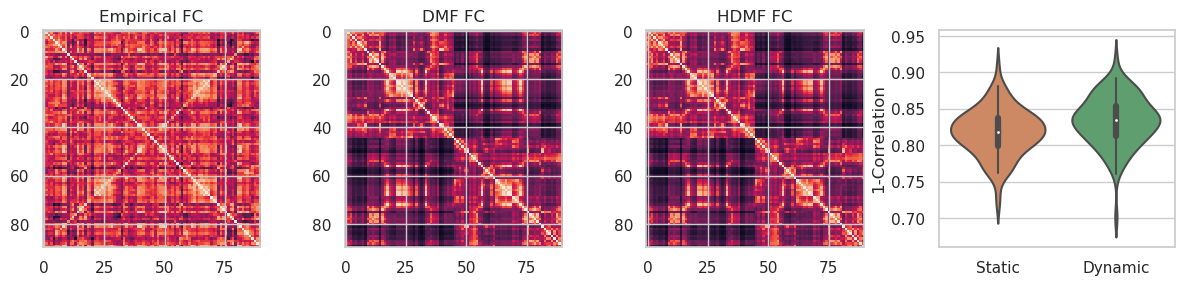

In [37]:
# Plotting repeated simulations at optima for FCD
ave_static_fc = np.mean(fc_reps[0,:,:,:],axis=0)
ave_dynamic_fc = np.mean(fc_reps[1,:,:,:],axis=0)
figname = 'FC_repeated_sim_fit'
col_pal = sns.color_palette()

fig = plt.figure(figsize=(12, 8))

# FC matrices
plt.subplot(3,4,1)
plt.imshow(fc_fit[0]['emp_fc'], interpolation='none')
plt.title('Empirical FC')

plt.subplot(3,4,2)
plt.imshow(ave_static_fc, interpolation='none')
plt.title('DMF FC')

plt.subplot(3,4,3)
plt.imshow(ave_dynamic_fc, interpolation='none')
plt.title('HDMF FC')

# Violins with goodness of fit
plt.subplot(3,4,4)
sns.violinplot(1-rep_corr.T, palette=col_pal[1:3])
plt.xticks(ticks=[0,1], labels=['Static', 'Dynamic'])
plt.ylabel('1-Correlation')

plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.svg')


Text(0, 0.5, '1-Correlation')

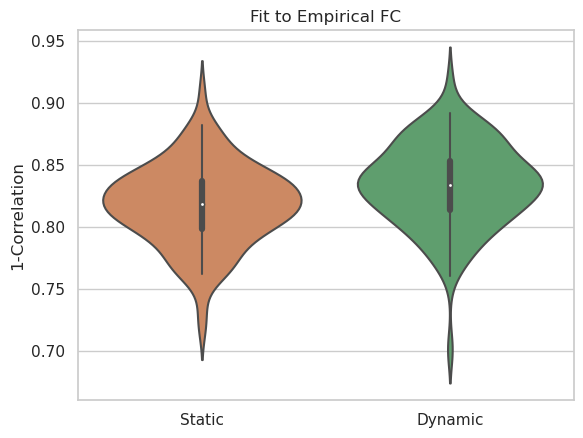

In [36]:
sns.violinplot(1-rep_corr.T, palette=col_pal[1:3])
plt.xticks(ticks=[0,1], labels=['Static', 'Dynamic'])
plt.title("Fit to Empirical FC")
plt.ylabel('1-Correlation')

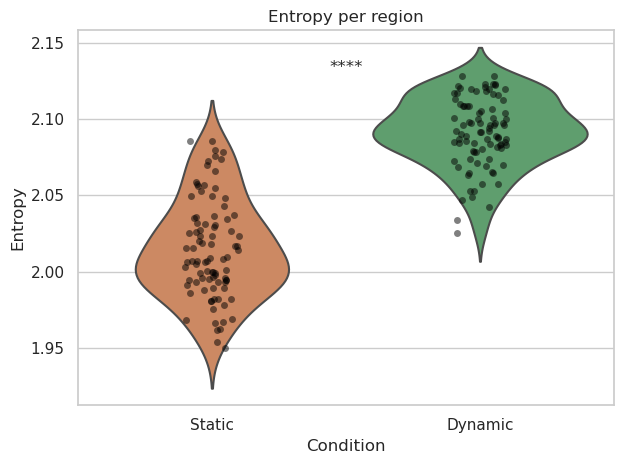

In [39]:
sns.stripplot(x='Condition', y='Entropy', data=data, jitter=True, color='black', alpha=0.5)
sns.violinplot(x='Condition', y='Entropy', data=data, inner=None,palette=col_pal[1:3])
plt.title('Entropy per region')
# Add paired test to see if distributions are different
_, p = ks_2samp(entropies_stat, entropies_dyn)
if p < 0.05:
    plt.text(0.5, 0.9, '****', ha='center', va='center', transform=plt.gca().transAxes)


plt.ylabel('Entropy')


plt.tight_layout()
plt.show()

In [ ]:

# Violins with goodness of fit
plt.subplot(3,4,5)
sns.violinplot(1-rep_corr.T, palette=col_pal[1:3])
plt.xticks(ticks=[0,1], labels=['Static', 'Dynamic'])
plt.title("Fit to Empirical FC")
plt.ylabel('1-Correlation')

plt.subplot(3, 4, 6)
sns.stripplot(x='Condition', y='Entropy', data=data, jitter=True, color='black', alpha=0.5)
sns.violinplot(x='Condition', y='Entropy', data=data, inner=None)
plt.title('Entropy per region')
# Add paired test to see if distributions are different
_, p = ks_2samp(entropies_stat, entropies_dyn)
if p < 0.05:
    plt.text(0.5, 0.9, '****', ha='center', va='center', transform=plt.gca().transAxes)


plt.ylabel('Entropy')


plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.svg')


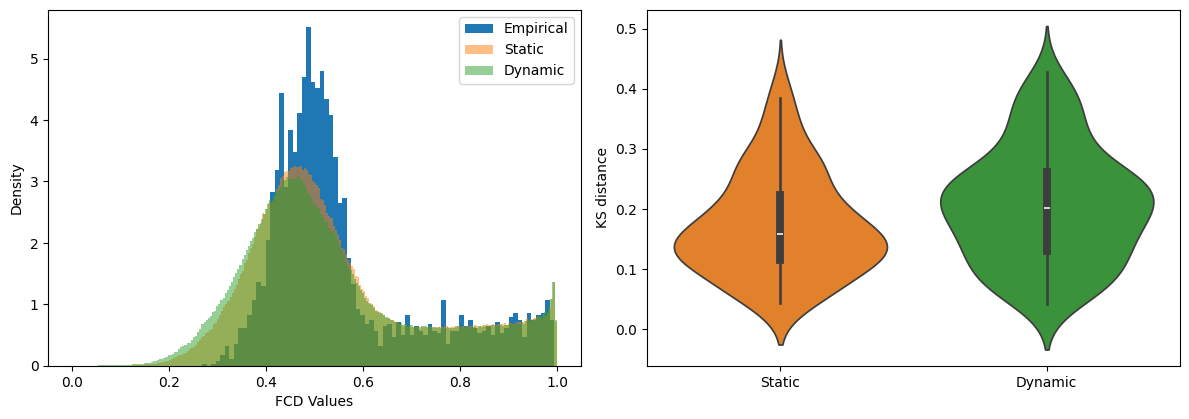

In [67]:
# Plotting repeated simulations at optima for FCD
figname = 'FCD_repeated_sim_fit'
col_pal = sns.color_palette()

fig = plt.figure(figsize=(12, 8))
# STATIC FC FIT
plt.subplot(2,2,1)
sns.histplot(emp_fcd, stat='density', legend=False, linewidth=0, label='Empirical', alpha=1)
sns.histplot(sim_fcd_stat, stat='density', legend=False, linewidth=0, label='Static', alpha=0.5)
sns.histplot(sim_fcd_dyn, stat='density', legend=False, linewidth=0, label='Dynamic', alpha=0.5)
# sns.histplot([emp_fcd, sim_fcd_stat, sim_fcd_dyn], stat='percent', legend=False)
# plt.hist([emp_fcd, sim_fcd_stat, sim_fcd_dyn], density=True)
# sns.histplot([sim_fcd_dyn], stat='percent', legend=False)
# plt.legend(['Empirical','Static','Dynamic'])
plt.xlabel('FCD Values')
plt.legend()


plt.subplot(2,2,2)
sns.violinplot(rep_ks.T, palette=col_pal[1:3])
plt.xticks(ticks=[0,1], labels=['Static', 'Dynamic'])
plt.ylabel('KS distance')

plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.svg')


In [64]:
# Statistcal tests between distributions
from scipy.stats import wilcoxon
ks, p_fcd = ks_2samp(rep_ks[0,:],rep_ks[1,:])
ks_corr, p_fc = ks_2samp(rep_corr[0,:],rep_corr[1,:])

_, w_p_fcd= wilcoxon(rep_ks[0,:],rep_ks[1,:])
_, w_p_fc= wilcoxon(rep_corr[0,:],rep_corr[1,:])
[p_fcd, p_fc, w_p_fcd,w_p_fc]

[0.009878183186176536,
 0.0061340334218580265,
 0.0005853250706648852,
 3.3463326057616274e-10]

## Falta figura con las entropías de las regiones

In [ ]:
wilcoxon(rep_corr[0,:],rep_corr[1,:])

WilcoxonResult(statistic=698.0, pvalue=3.3463326057616274e-10)

## Plotting timeserires and autocorrelation function

In [31]:
e_rates_tseries = np.load('/home/ivan.mindlin/Desktop/DatosParaRubenOldData/slow_waves/time_series_examples/rates_results.npy')
rates_tseries = np.load('/home/ivan.mindlin/Desktop/DatosParaRubenOldData/slow_waves/time_series_examples/rates_inh_results.npy')
fic_tseries = np.load('/home/ivan.mindlin/Desktop/DatosParaRubenOldData/slow_waves/time_series_examples/fic_t_results.npy')
gvals_tseries = np.load('/home/ivan.mindlin/Desktop/DatosParaRubenOldData/slow_waves/time_series_examples/G_vals.npy')
np.shape(e_rates_tseries)

(3, 90, 90000)

In [32]:
from scipy.signal import find_peaks, correlate

def get_peak_and_ms(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = np.mean(rates, axis=0)
    signal -= np.mean(signal)

    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    peaks, _ = find_peaks(autocorr, height=(0.2,0.8), prominence=0.2)
    if peaks.size==0:
        autocorr_value = 0
        time = 0
    else:
        autocorr_value = autocorr[peaks[0]]
        time = peaks[0]
    return autocorr, autocorr_value, time

def cross_corr(x, y):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = np.mean(rates, axis=0)
    signal -= np.mean(signal)

    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]

    return crosscorr


In [33]:
acorr = list()
acorr_peak = np.zeros((3))
acorr_time = np.zeros((3))
xcorr_rate_fic = list()
for d in range(3):
    aux_acorr, acorr_peak[d], acorr_time[d] = get_peak_and_ms(np.mean(e_rates_tseries[d,:,:],axis=0)[None,:])
    acorr.append(aux_acorr)
    # xcorr between fic and rates
    x=np.mean(e_rates_tseries[d,:,:],axis=0)
    x=(x-np.mean(x))/np.std(x)
    
    y=np.mean(fic_tseries[d,:,:],axis=0)
    y=(y-np.mean(y))/np.std(y)
    corr = correlate(x, y, mode='full')             
    xcorr_rate_fic.append(corr/len(x))    
    
acorrs = np.vstack((acorr))
np.shape(acorrs)    
    

(3, 90000)

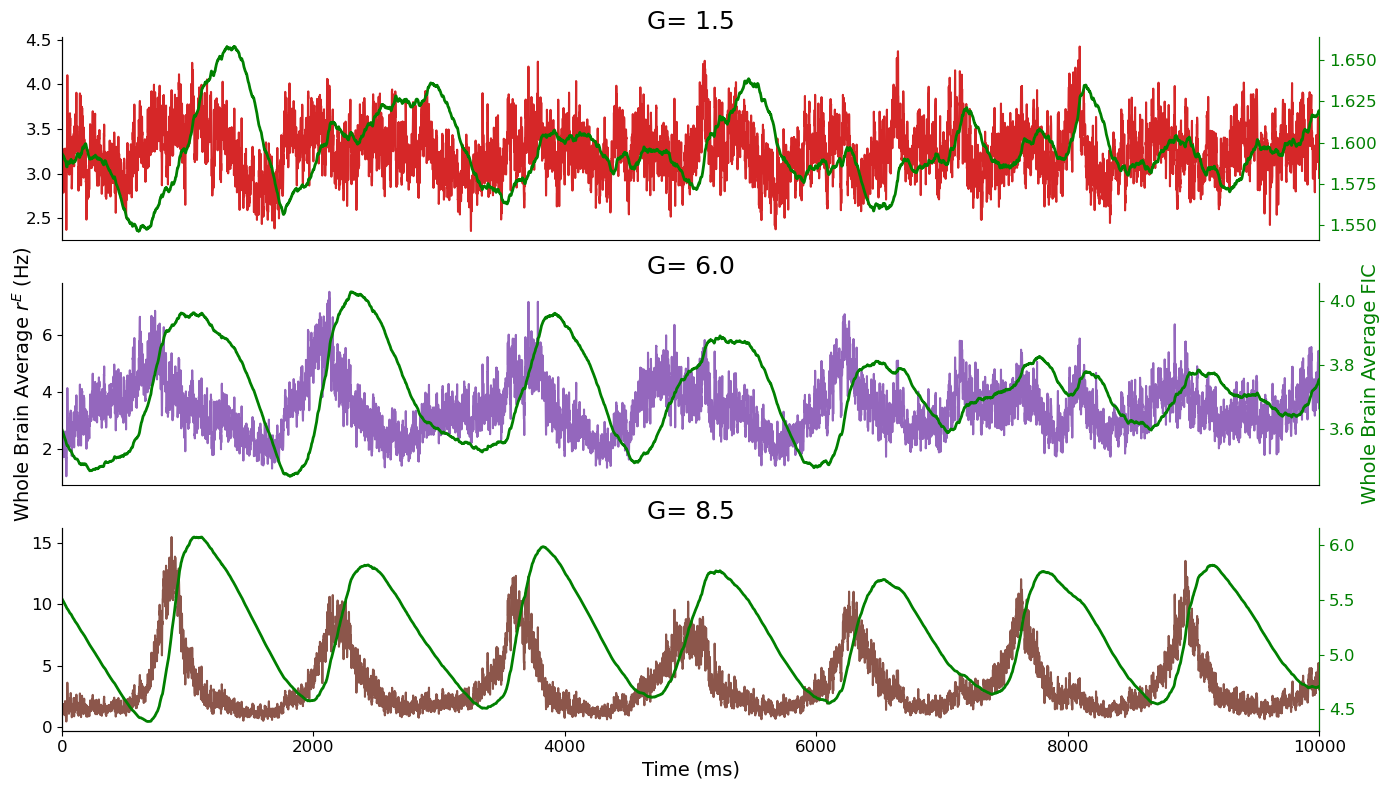

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

# Parameters
max_t = 10000
acor_tbase = np.arange(0, max_t)
acor_tbase_s = acor_tbase * 0.001
figname = 'FIG_5'
col_pal = sns.color_palette()

# Create the figure
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

for e in range(3):
    ax = axes[e]
    ax.plot(acor_tbase, np.mean(e_rates_tseries[e, :, :max_t], axis=0), color=col_pal[3 + e], label=r'$r^E$')
    
    # Create a twin Axes for the right y-axis
    ax2 = ax.twinx()
    ax2.plot(acor_tbase, np.mean(fic_tseries[e, :, :max_t], axis=0), color='green', linewidth=2, label='FIC')
    
    # Labels and Titles
    if e==1:
        ax.set_ylabel(r'Whole Brain Average $r^E$ (Hz)', fontsize=LABEL)
        ax2.set_ylabel(r'Whole Brain Average FIC', fontsize=LABEL, color='green')
    ax.set_title(f'G= {gvals_tseries[e]}', fontsize=TITLE)
    
    # Customize the right y-axis ticks and line color
    ax2.yaxis.set_tick_params(color='green', labelcolor='green')
    ax2.spines['right'].set_color('green')
    
    # Hide x-axis ticks for the first two plots
    if e == 2:
        ax.set_xlabel('Time (ms)', fontsize=LABEL)
    else:
        ax.set_xticks([])
    
    # Axes properties
    ax.tick_params(axis='both', labelsize=TICKS)
    ax2.tick_params(axis='y', labelsize=TICKS)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(e == 2)  # Bottom spine visible only for the last plot
    ax2.spines['top'].set_visible(False)
    
    # Set x-axis limits
    ax.set_xlim([0, max_t])

plt.tight_layout()

# Save the figure
fig.savefig(figfold + figname + '_A.png', dpi=300)
fig.savefig(figfold + figname + '_A.svg', dpi=300)
plt.show()


In [73]:
acorr = list()
acorr_peak = np.zeros((3))
acorr_time = np.zeros((3))
xcorr_rate_fic = list()
for d in range(3):
    aux_acorr, acorr_peak[d], acorr_time[d] = get_peak_and_ms(np.mean(e_rates_tseries[d,:,:],axis=0)[None,:])
    acorr.append(aux_acorr)
    # xcorr between fic and rates
    x=np.mean(e_rates_tseries[d,:,:],axis=0)
    x=(x-np.mean(x))/np.std(x)
    
    y=np.mean(fic_tseries[d,:,:],axis=0)
    y=(y-np.mean(y))/np.std(y)
    corr = correlate(x, y, mode='full')             
    xcorr_rate_fic.append(corr/len(x))    
    
acorrs = np.vstack((acorr))
np.shape(acorrs)    
    

(3, 90000)

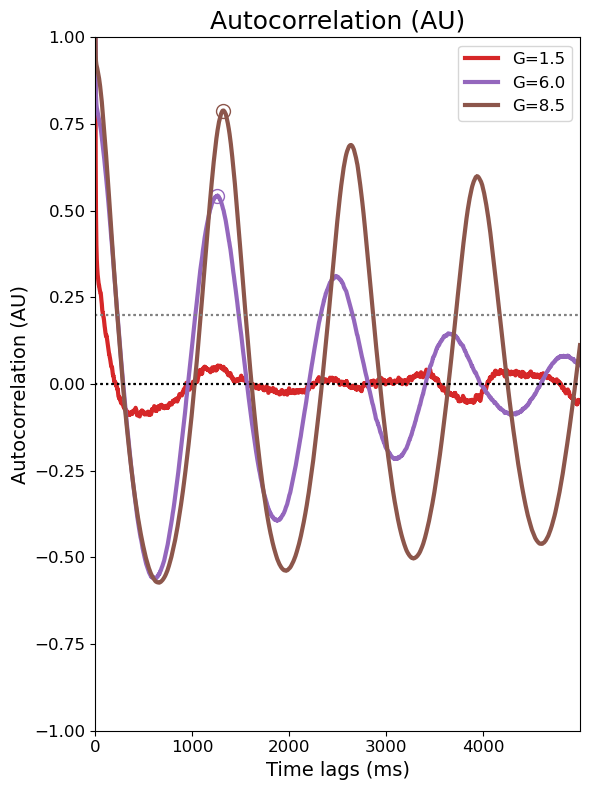

In [83]:
# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

# Parameters
figname_autocorr = 'FIG_5'


t_len = np.shape(acorrs)[1]
max_t = 5000
acor_tbase = np.arange(0,max_t)
acor_tbase_s = np.arange(0,max_t)*0.001
xcorr_tbase = np.arange(- max_t/2, max_t/2)

# Extacting max of the xcorr
sel_xcorr = np.vstack(([x[int(t_len - max_t/2):int(t_len + max_t/2)] for x in xcorr_rate_fic]))
max_xcorr_id = np.argmax(sel_xcorr, axis=1)
min_xcorr_id = np.argmin(sel_xcorr, axis=1)
# [[[sel_xcorr[x,min_xcorr_id[x]] for x in range(3)], xcorr_tbase[min_xcorr_id]],
# [[sel_xcorr[x,max_xcorr_id[x]] for x in range(3)], xcorr_tbase[max_xcorr_id]]]

# Autocorrelation Plot
fig1 = plt.figure(figsize=(6, 8))
for e in range(3):
    plt.plot(acor_tbase, acorrs[e, 0:max_t], color=col_pal[3 + e], linewidth=3, label=f'G={gvals_tseries[e]}')
    if e > 0:
        plt.plot(acorr_time[e], acorr_peak[e], 'o', color=col_pal[3 + e],
                 markersize=10, fillstyle='none')
    plt.ylim([-1, 1])
    plt.plot([acor_tbase[0], acor_tbase[-1]], [0, 0], 'k:')
    plt.plot([acor_tbase[0], acor_tbase[-1]], [0.2, 0.2], ':', color=[0.5, 0.5, 0.5])
    plt.xlim([acor_tbase[0], acor_tbase[-1]])
    
plt.title('Autocorrelation (AU)', fontsize=TITLE)
plt.xlabel('Time lags (ms)', fontsize=LABEL)
plt.ylabel('Autocorrelation (AU)', fontsize=LABEL)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.legend(fontsize=LEGEND)
plt.tight_layout()

# Save Autocorrelation Plot
fig1.savefig(figfold + figname_autocorr + '_B.png', dpi=300)
fig1.savefig(figfold + figname_autocorr + '_B.svg', dpi=300)
plt.show()




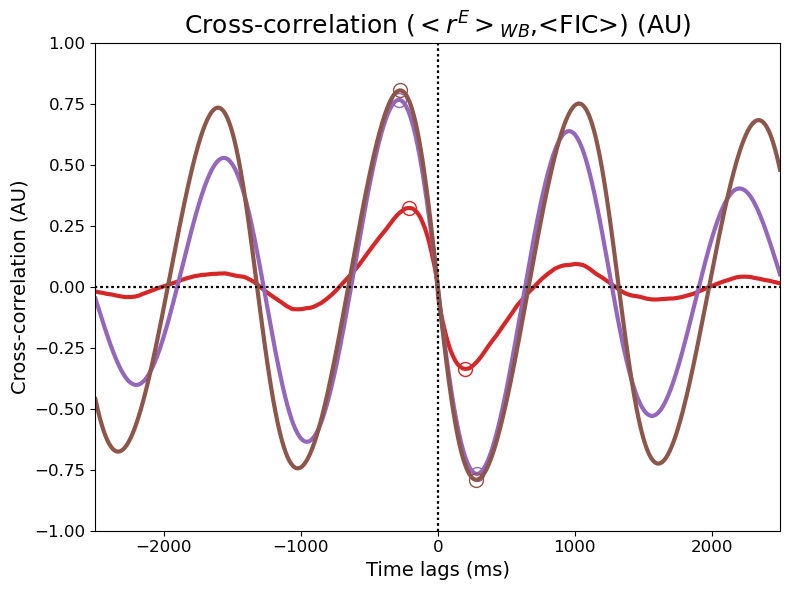

In [75]:
# Cross-correlation Plot
figname_crosscorr = 'Supp_Fig_5'
fig2 = plt.figure(figsize=(8, 6))
for e in range(3):
    plt.plot(xcorr_tbase, xcorr_rate_fic[e][int(t_len - max_t / 2):int(t_len + max_t / 2)], 
             color=col_pal[3 + e], linewidth=3)
    plt.plot(xcorr_tbase[max_xcorr_id[e]], sel_xcorr[e, max_xcorr_id[e]], 
             'o', color=col_pal[3 + e], markersize=10, fillstyle='none')
    plt.plot(xcorr_tbase[min_xcorr_id[e]], sel_xcorr[e, min_xcorr_id[e]], 
             'o', color=col_pal[3 + e], markersize=10, fillstyle='none')
    plt.ylim([-1, 1])
    plt.plot([0, 0], [-1, 1], 'k:')
    plt.plot([xcorr_tbase[0], xcorr_tbase[-1]], [0, 0], 'k:')
    plt.xlim([xcorr_tbase[0], xcorr_tbase[-1]])
    
plt.title('Cross-correlation ($<r^E>_{WB}$,<FIC>) (AU)', fontsize=TITLE)
plt.xlabel('Time lags (ms)', fontsize=LABEL)
plt.ylabel('Cross-correlation (AU)', fontsize=LABEL)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.tight_layout()

# Save Cross-correlation Plot
fig2.savefig(figfold + figname_crosscorr + '_B.png', dpi=300)
fig2.savefig(figfold + figname_crosscorr + '_B.svg', dpi=300)
plt.show()

### III.- A potential mechanism for whole-brain slow-waves

In [4]:
peak_val_ac_grid = np.load(datafolder+'slow_waves/peak_autocorrelation_grid.npy')
peak_time_ac_grid = np.load(datafolder+'slow_waves/peak_time_grid.npy')
corr_to_sc_grid = np.load(datafolder+'slow_waves/corr_to_sc_grid.npy')
rates_grid = np.load(datafolder+'slow_waves/rates_grid.npy')
homeo_fit_grid = np.load(datafolder+'slow_waves/homeostatic_fittness_grid.npy')

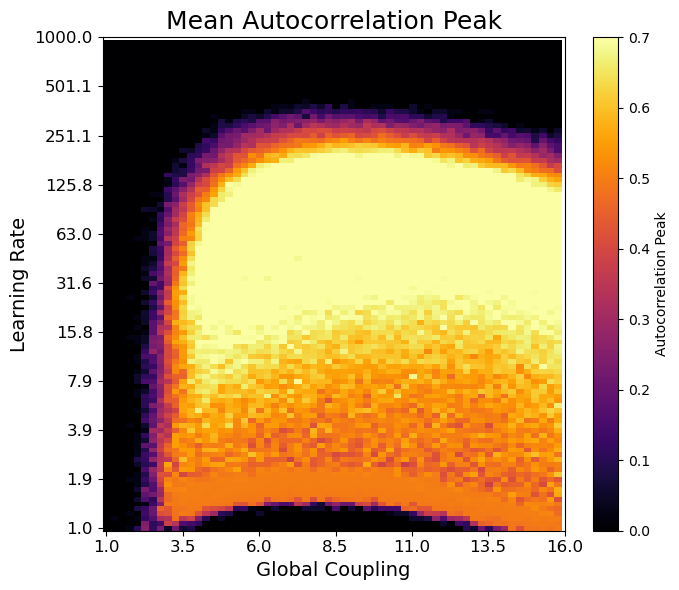

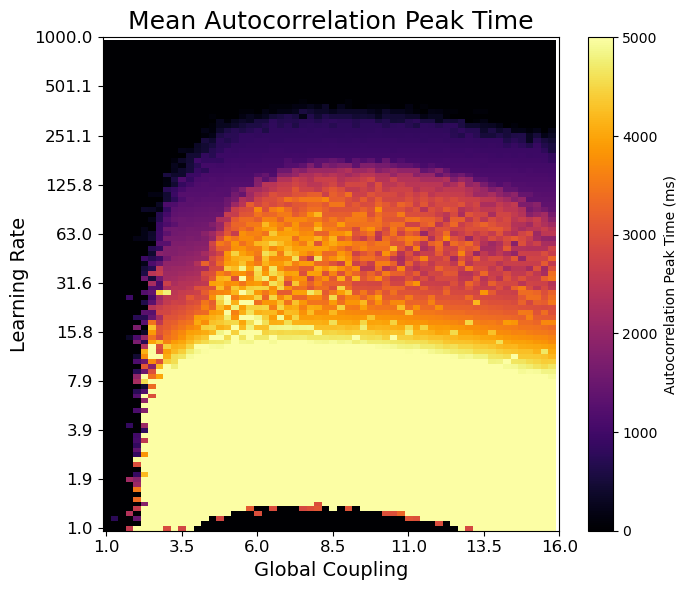

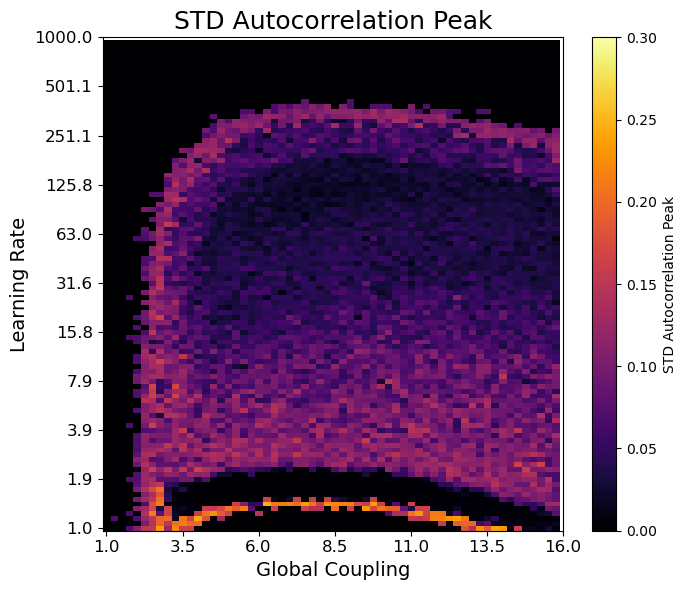

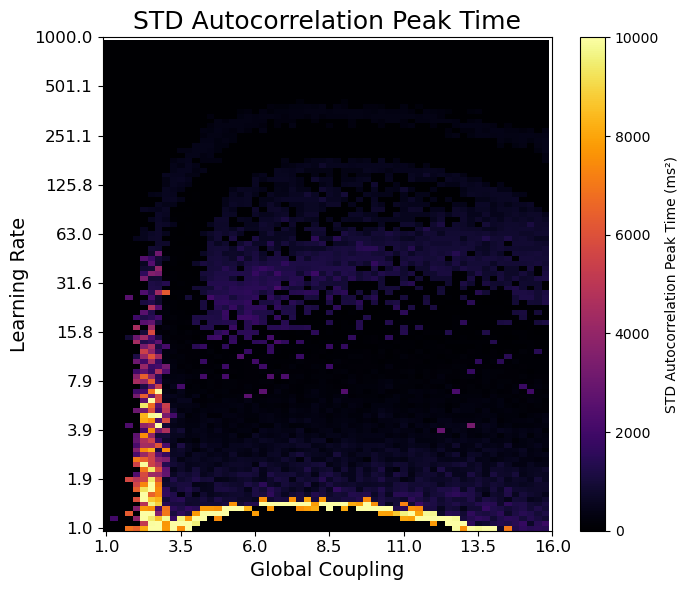

In [13]:

# Parameters
figname = 'FIG_5'
G_max = 16
G_step = 0.25
G_range = np.arange(1, G_max, G_step)
LR_range = np.logspace(0, 3, 100)
ngs = len(G_range)
nlrs = len(LR_range)

# Define common y and x ticks
yticks = np.arange(0, nlrs + 1, 10)
ytick_labels = np.floor(10 * np.logspace(0, 3, 11)) / 10
xticks = np.arange(0, ngs + 1, 10)
xtick_labels = np.linspace(1, G_max, 7)

# FIG_5A: Mean Autocorrelation Peak
fig1 = plt.figure(figsize=(7, 6))
plt.imshow(np.mean(peak_val_ac_grid, axis=0).T, vmin=0, vmax=0.7, cmap='inferno',
           interpolation='none', origin='lower', aspect='auto')
plt.yticks(ticks=yticks, labels=ytick_labels, fontsize=TICKS)
plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=TICKS)
plt.ylabel('Learning Rate', fontsize=LABEL)
plt.xlabel('Global Coupling', fontsize=LABEL)
plt.colorbar(label='Autocorrelation Peak')
plt.title('Mean Autocorrelation Peak', fontsize=TITLE)
plt.tight_layout()
plt.show()
fig1.savefig(figfold + figname + '_C.png', dpi=300)
fig1.savefig(figfold + figname + '_C.svg', dpi=300)

# FIG_5B: Mean Autocorrelation Peak Time
fig2 = plt.figure(figsize=(7, 6))
plt.imshow(np.mean(peak_time_ac_grid, axis=0).T, vmin=0, vmax=5000, cmap='inferno',
           interpolation='none', origin='lower', aspect='auto')
plt.yticks(ticks=yticks, labels=ytick_labels, fontsize=TICKS)
plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=TICKS)
plt.ylabel('Learning Rate', fontsize=LABEL)
plt.xlabel('Global Coupling', fontsize=LABEL)
plt.colorbar(label='Autocorrelation Peak Time (ms)')
plt.title('Mean Autocorrelation Peak Time', fontsize=TITLE)
plt.tight_layout()
plt.show()
fig2.savefig(figfold + figname + '_D.png', dpi=300)
fig2.savefig(figfold + figname + '_D.svg', dpi=300)

# FIG_5C: STD of Autocorrelation Peak
fig3 = plt.figure(figsize=(7, 6))
plt.imshow(np.std(peak_val_ac_grid, axis=0).T, vmin=0, vmax=0.3, cmap='inferno',
           interpolation='none', origin='lower', aspect='auto')
plt.yticks(ticks=yticks, labels=ytick_labels, fontsize=TICKS)
plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=TICKS)
plt.ylabel('Learning Rate', fontsize=LABEL)
plt.xlabel('Global Coupling', fontsize=LABEL)
plt.colorbar(label='STD Autocorrelation Peak')
plt.title('STD Autocorrelation Peak', fontsize=TITLE)
plt.tight_layout()
plt.show()
fig3.savefig(figfold + figname + '_E.png', dpi=300)
fig3.savefig(figfold + figname + '_E.svg', dpi=300)

# FIG_5D: STD of Autocorrelation Peak Time
fig4 = plt.figure(figsize=(7, 6))
plt.imshow(np.std(peak_time_ac_grid, axis=0).T, vmin=0, vmax=10000, cmap='inferno',
           interpolation='none', origin='lower', aspect='auto')
plt.yticks(ticks=yticks, labels=ytick_labels, fontsize=TICKS)
plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=TICKS)
plt.ylabel('Learning Rate', fontsize=LABEL)
plt.xlabel('Global Coupling', fontsize=LABEL)
plt.colorbar(label='STD Autocorrelation Peak Time (ms²)')
plt.title('STD Autocorrelation Peak Time', fontsize=TITLE)
plt.tight_layout()
plt.show()
fig4.savefig(figfold + figname + '_F.png', dpi=300)
fig4.savefig(figfold + figname + '_F.svg', dpi=300)

## Overlapping fitting with slow waves

## FIG 6

In [5]:
awake_fit = loadmat(datafolder+'FitteoObservables/results_awake_dyn_fcd.mat')
deep_fit = loadmat(datafolder+'FitteoObservables/results_deep_dyn_fcd.mat')

### Example overalp with fix autocorr and time

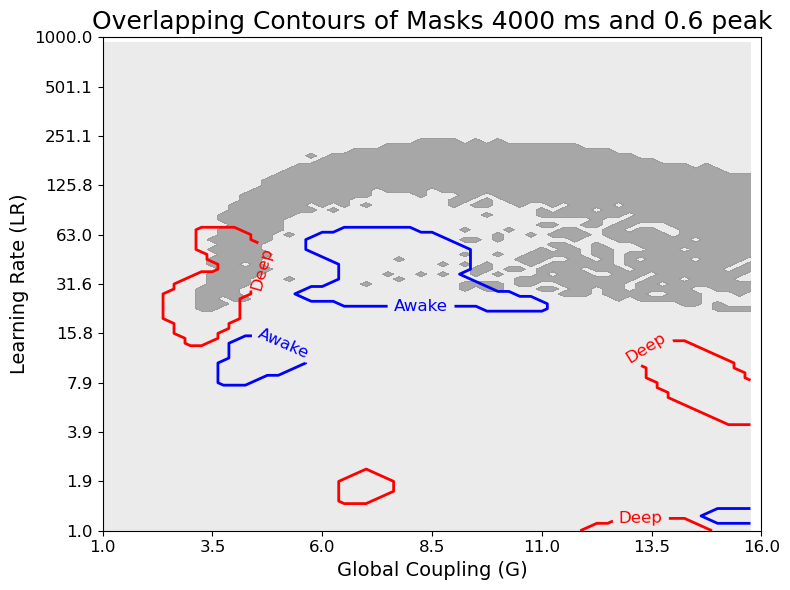

In [35]:

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

autocorrelation_mask = np.array(np.mean(peak_val_ac_grid, axis=0) > 0.5).astype(int)
time_mask = (np.mean(peak_time_ac_grid, axis=0) < 3000).astype(int)
slow_wave_mask = autocorrelation_mask & time_mask
awake_contour = awake_fit['minRegionMask']
# Count the amount of overlap between the two masks
overlap_awake_count = np.sum(autocorrelation_mask & awake_contour)

deep_contour = deep_fit['minRegionMaskDeep']
overlap_deep_count = np.sum(autocorrelation_mask & deep_contour)


# Parameters
figname = 'Fig_6_D'

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the autocorrelation mask as a filled contour for a background
ax.contourf(slow_wave_mask.T, levels=[0, 0.5, 1], cmap='Greys', alpha=0.5)

# Plot the awake contour lines
awake_levels = [0.5]  # Threshold for contour line
cs_awake = ax.contour(awake_contour.T, levels=awake_levels, colors='blue', linewidths=2)
ax.clabel(cs_awake, inline=True, fontsize=TICKS, fmt="Awake")

# Plot the deep contour lines
deep_levels = [0.5]  # Threshold for contour line
cs_deep = ax.contour(deep_contour.T, levels=deep_levels, colors='red', linewidths=2)
ax.clabel(cs_deep, inline=True, fontsize=TICKS, fmt="Deep")

# Labels, Title, and Axes
ax.set_title(f"Overlapping Contours of Masks {time_range[40]} ms and {peak_range[60]} peak", fontsize=TITLE)
ax.set_xlabel("Global Coupling (G)", fontsize=LABEL)
ax.set_ylabel("Learning Rate (LR)", fontsize=LABEL)

# Set the appropriate G and LR parameter ranges
ax.set_xticks(ticks=np.arange(0, ngs + 1, 10))
ax.set_xticklabels(labels=np.linspace(1, G_max, 7), fontsize=TICKS)
ax.set_yticks(ticks=np.arange(0, nlrs + 1, 10))
ax.set_yticklabels(labels=np.floor(10 * np.logspace(0, 3, 11)) / 10, fontsize=TICKS)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(figfold + figname + '.svg', dpi=300)
fig.savefig(figfold + figname + '.pdf', dpi=300)


### Generalize effect of overlap

/tmp/ipykernel_2206246/614413260.py:16: RuntimeWarning: invalid value encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / pooled_std


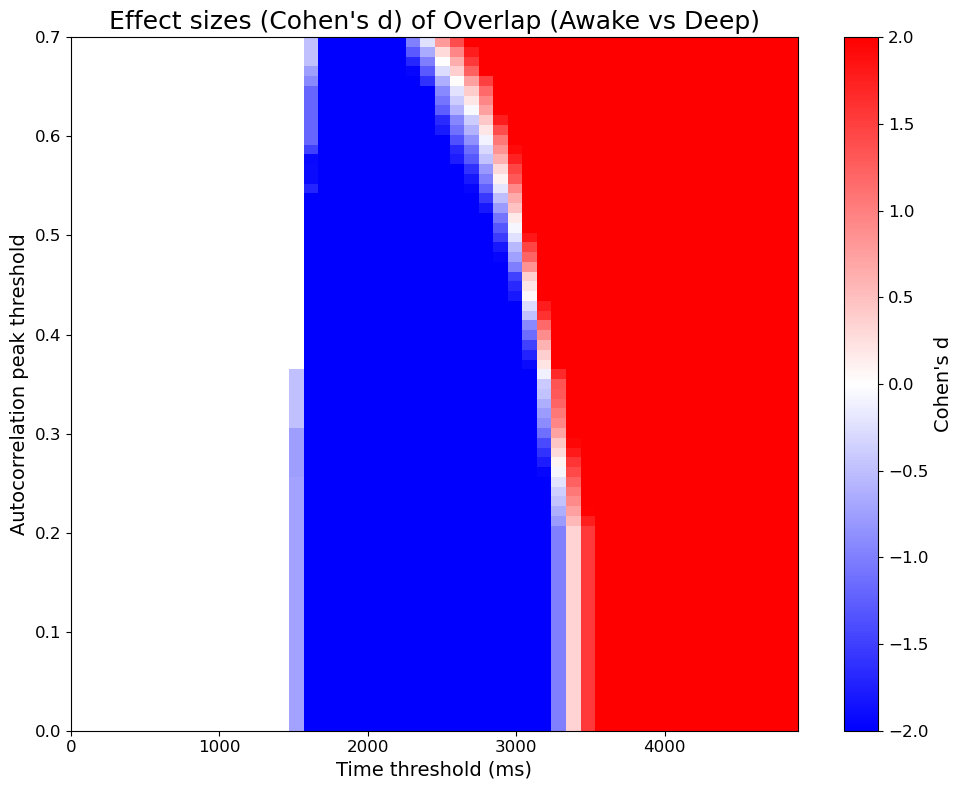

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
COLORBAR = 14

def cohen_d(x, y):
    # Cohen's d for two independent samples
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / dof)
    d = (np.mean(x) - np.mean(y)) / pooled_std
    return d

# Parameters
time_range = np.arange(0, 5000, 100)  # shape (50,)
peak_range = np.arange(0, 0.71, 0.01) # shape (71,)

# Averaged Overlap 
overlap_awake = np.zeros((len(time_range), len(peak_range)))
overlap_deep = np.zeros((len(time_range), len(peak_range)))

# Overlaps for each repetition:
overlap_awake_all = np.zeros((8, len(time_range), len(peak_range)))
overlap_deep_all = np.zeros((8, len(time_range), len(peak_range)))

awake_contour = awake_fit['minRegionMask'].astype(int)
deep_contour = deep_fit['minRegionMaskDeep'].astype(int)

# Use the total area of optimal points to normalize the overlaps
total_awake = np.sum(awake_contour)
total_deep = np.sum(deep_contour)


# Calculate overlaps
for idx_t, t in enumerate(time_range):
    for idx_p, peak in enumerate(peak_range):
        for r in range(8):  # 8 repetitions
            autocorrelation_mask = (peak_val_ac_grid[r] > peak).astype(int)
            time_mask = (peak_time_ac_grid[r] < t).astype(int)
            sw_mask = autocorrelation_mask & time_mask

            overlap_awake_all[r, idx_t, idx_p] = np.sum(sw_mask & awake_contour) / total_awake
            overlap_deep_all[r, idx_t, idx_p]  = np.sum(sw_mask & deep_contour) / total_deep
        # Use average to see tendency
        autocorrelation_mask = (np.mean(peak_val_ac_grid, axis=0) > peak).astype(int)
        time_mask = (np.mean(peak_time_ac_grid, axis=0) < t).astype(int)
        sw_mask = autocorrelation_mask & time_mask
        overlap_awake[idx_t, idx_p] = np.sum(sw_mask & awake_contour) / total_awake
        overlap_deep[idx_t, idx_p] = np.sum(sw_mask & deep_contour) / total_deep


# Compute effect sizes for each (t, peak)
effect_sizes = np.zeros((len(time_range), len(peak_range)))

for idx_t in range(len(time_range)):
    for idx_p in range(len(peak_range)):
        awake_vals = overlap_awake_all[:, idx_t, idx_p]
        deep_vals = overlap_deep_all[:, idx_t, idx_p]
        effect_sizes[idx_t, idx_p] = cohen_d(awake_vals, deep_vals)

# Plot effect sizes
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(effect_sizes.T, origin='lower', aspect='auto',
                extent=(time_range[0], time_range[-1], peak_range[0], peak_range[-1]),
                interpolation='none', cmap='bwr', vmin=-2, vmax=2)

# Add labels and title with font sizes
ax.set_xlabel('Time threshold (ms)', fontsize=LABEL)
ax.set_ylabel('Autocorrelation peak threshold', fontsize=LABEL)
ax.set_title('Effect sizes (Cohen\'s d) of Overlap (Awake vs Deep)', fontsize=TITLE)

# Adjust ticks
ax.tick_params(axis='both', labelsize=TICKS)

# Add colorbar
cbar = fig.colorbar(cax, label='Cohen\'s d')
cbar.ax.tick_params(labelsize=TICKS)
cbar.set_label('Cohen\'s d', fontsize=COLORBAR)

plt.tight_layout()
plt.show()


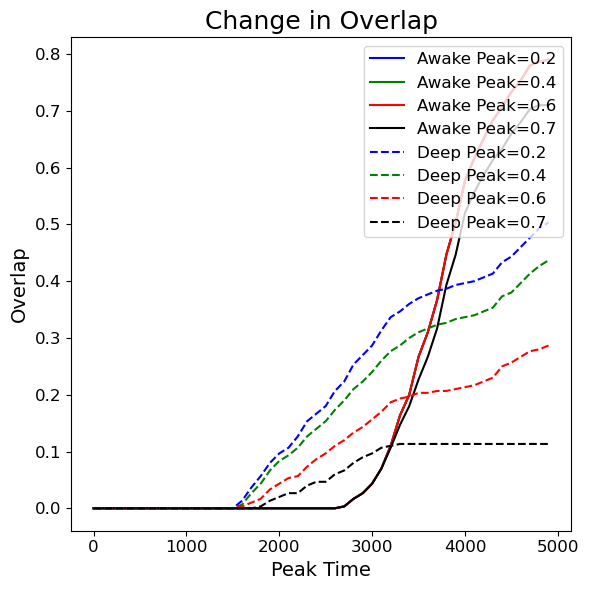

In [32]:
# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

# Parameters
figname = 'overlap_awake_deep'

# Plot
fig = plt.figure(figsize=(6, 6))

# Awake Overlap
plt.plot(time_range, overlap_awake[:, 20], label='Awake Peak=0.2', color='blue')
plt.plot(time_range, overlap_awake[:, 40], label='Awake Peak=0.4', color='green')
plt.plot(time_range, overlap_awake[:, 60], label='Awake Peak=0.6', color='red')
plt.plot(time_range, overlap_awake[:, 70], label='Awake Peak=0.7', color='black')

# Deep Overlap
plt.plot(time_range, overlap_deep[:, 20], label='Deep Peak=0.2', linestyle='--', color='blue')
plt.plot(time_range, overlap_deep[:, 40], label='Deep Peak=0.4', linestyle='--', color='green')
plt.plot(time_range, overlap_deep[:, 60], label='Deep Peak=0.6', linestyle='--', color='red')
plt.plot(time_range, overlap_deep[:, 70], label='Deep Peak=0.7', linestyle='--', color='black')

# Labels and Legend
plt.xlabel('Peak Time', fontsize=LABEL)
plt.ylabel('Overlap', fontsize=LABEL)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.legend(fontsize=LEGEND, loc='upper right')
plt.title('Change in Overlap', fontsize=TITLE)

plt.tight_layout()
plt.show()

# Save the Figure
fig.savefig(figfold + figname + '.svg', dpi=300)
fig.savefig(figfold + figname + '.pdf', dpi=300)


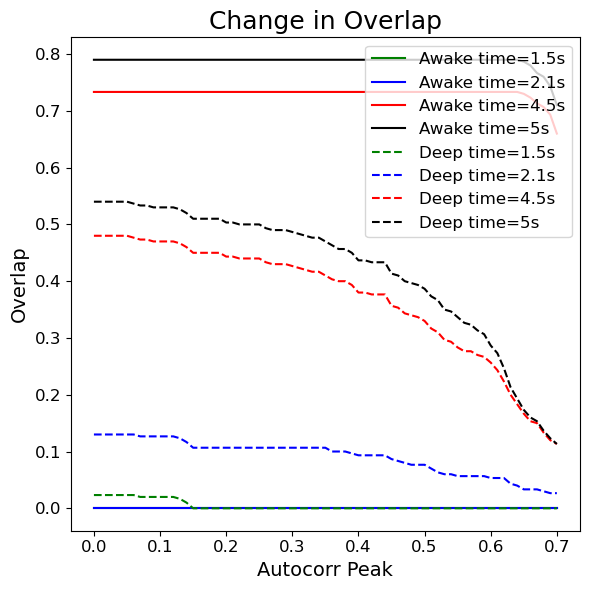

In [33]:
# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

# Parameters
figname = 'overlap_awake_deep'

# Plot
fig = plt.figure(figsize=(6, 6))

# Awake Overlap
plt.plot(peak_range, overlap_awake[15, :], label='Awake time=1.5s', color='green')
plt.plot(peak_range, overlap_awake[21, :], label='Awake time=2.1s', color='blue')
plt.plot(peak_range, overlap_awake[45, :], label='Awake time=4.5s', color='red')
plt.plot(peak_range, overlap_awake[49, :], label='Awake time=5s', color='black')

# Deep Overlap
plt.plot(peak_range, overlap_deep[15, :], label='Deep time=1.5s', color='green', linestyle='--')
plt.plot(peak_range, overlap_deep[21, :], label='Deep time=2.1s', color='blue', linestyle='--')
plt.plot(peak_range, overlap_deep[45, :], label='Deep time=4.5s', color='red', linestyle='--')
plt.plot(peak_range, overlap_deep[49, :], label='Deep time=5s', color='black', linestyle='--')

# Labels and Title
plt.xlabel('Autocorr Peak', fontsize=LABEL)
plt.ylabel('Overlap', fontsize=LABEL)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.title('Change in Overlap', fontsize=TITLE)

# Legend
plt.legend(fontsize=LEGEND, loc='upper right')

# Layout and Display
plt.tight_layout()
plt.show()

# Save the Figure
fig.savefig(figfold + figname + '.svg', dpi=300)
fig.savefig(figfold + figname + '.pdf', dpi=300)
